# Opening Range Breakout (ORB) Strategy - Group 2

This notebook implements an Opening Range Breakout trading strategy adapted for Group 2 assets:
- **CAD** - Canadian Dollar futures
- **AUD** - Australian Dollar futures  
- **XAU** - Gold futures
- **XAG** - Silver futures

## Key Adaptations for Group 2:
1. **Frequency**: 5-minute bars (vs 1-minute for Group 1)
2. **Trading Hours**: 24-hour with 1-hour break (17:00-18:00 CET)
3. **Trading Days**: Sunday 18:00 to Friday 17:00
4. **Break Management**: Exit all positions at 16:50, no trading until 18:10
5. **Different Contract Specs**: Varying point values and transaction costs per asset

## 1. Library Imports and Configuration

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Group 2 specifications
POINT_VALUE = {
    "CAD": 100000.0,  # Canadian Dollar
    "AUD": 100000.0,  # Australian Dollar
    "XAU": 100.0,     # Gold
    "XAG": 5000.0     # Silver
}

TX_COST = {
    "CAD": 10.0,
    "AUD": 10.0,
    "XAU": 15.0,
    "XAG": 10.0
}

DATA_DIR = Path("../data")

# Verifying data files exist
data2_files = sorted(DATA_DIR.glob("data2_*.parquet"))
print(f"Found {len(data2_files)} Group 2 data files:")
for f in data2_files:
    print(f"  - {f.name}")

Found 7 Group 2 data files:
  - data2_2023_Q1.parquet
  - data2_2023_Q3.parquet
  - data2_2023_Q4.parquet
  - data2_2024_Q2.parquet
  - data2_2024_Q4.parquet
  - data2_2025_Q1.parquet
  - data2_2025_Q2.parquet


## 2. Data Loading and Inspection

In [2]:
# Loading first quarter to inspect structure
df_sample = pd.read_parquet(data2_files[0])

if "datetime" in df_sample.columns:
    df_sample["datetime"] = pd.to_datetime(df_sample["datetime"])
    df_sample = df_sample.set_index("datetime")
else:
    df_sample.index = pd.to_datetime(df_sample.index)

df_sample = df_sample.sort_index()

print("\nData Structure:")
print(df_sample.info())
print("\nFirst few rows:")
print(df_sample.head(20))
print("\nData frequency check (time differences):")
print(df_sample.index.to_series().diff().value_counts().head())


Data Structure:
<class 'pandas.DataFrame'>
DatetimeIndex: 18398 entries, 2023-01-01 17:35:00+00:00 to 2023-03-31 17:00:00+00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AUD     17762 non-null  float64
 1   CAD     17761 non-null  float64
 2   XAG     17504 non-null  float64
 3   XAU     17504 non-null  float64
dtypes: float64(4)
memory usage: 718.7 KB
None

First few rows:
                               AUD       CAD  XAG  XAU
datetime                                              
2023-01-01 17:35:00+00:00      NaN       NaN  NaN  NaN
2023-01-01 18:00:00+00:00      NaN       NaN  NaN  NaN
2023-01-01 18:05:00+00:00  0.68142       NaN  NaN  NaN
2023-01-01 18:15:00+00:00  0.68123  0.739557  NaN  NaN
2023-01-01 18:20:00+00:00  0.68083  0.739552  NaN  NaN
2023-01-01 18:25:00+00:00  0.68083  0.739552  NaN  NaN
2023-01-01 18:30:00+00:00  0.68096  0.739410  NaN  NaN
2023-01-01 18:35:00+00:00  0.68096  0.739344  NaN  NaN
202

## 3. Trading Rules - Time Masks for Group 2

**Group 2 Specific Rules:**
- **Break Period**: 17:00-18:00 CET (1-hour market break)
- **Exit Before Break**: Close all positions at 16:50 (10 minutes before break)
- **No Trading After Break**: Wait until 18:10 (10 minutes after break resumes)
- **24-Hour Trading**: Sunday 18:00 to Friday 17:00

**Strategy Rationale:**
- Opening range defined during first hour after break (18:10-19:10)
- Avoids illiquid periods immediately after market reopens
- Ensures no positions held during market break

In [3]:
def add_group2_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Creates trading masks for Group 2:
    - No trading 18:00-18:10 (right after break)
    - Forced flat from 16:50-17:59 (before and during break)
    """
    t = index.time
    
    # No trading right after break (18:00-18:10)
    no_trade = (t >= pd.to_datetime("18:00").time()) & (t < pd.to_datetime("18:10").time())

    # Forced flat before and during break (16:50-17:59)
    flat_from = (t >= pd.to_datetime("16:50").time()) & (t < pd.to_datetime("18:00").time())
    
    return pd.DataFrame(
        {"mask_no_trade": no_trade, "mask_flat_from": flat_from},
        index=index
    )

# Testing masks on sample data
masks_sample = add_group2_masks(df_sample.index)
print("\nMask Statistics:")
print(f"No-trade periods: {masks_sample['mask_no_trade'].sum()} bars")
print(f"Forced-flat periods: {masks_sample['mask_flat_from'].sum()} bars")
print("\nSample mask application:")
print(masks_sample[masks_sample.any(axis=1)].head(10))


Mask Statistics:
No-trade periods: 123 bars
Forced-flat periods: 760 bars

Sample mask application:
                           mask_no_trade  mask_flat_from
datetime                                                
2023-01-01 17:35:00+00:00          False            True
2023-01-01 18:00:00+00:00           True           False
2023-01-01 18:05:00+00:00           True           False
2023-01-02 16:50:00+00:00          False            True
2023-01-02 16:55:00+00:00          False            True
2023-01-02 17:05:00+00:00          False            True
2023-01-02 17:15:00+00:00          False            True
2023-01-02 17:20:00+00:00          False            True
2023-01-02 17:25:00+00:00          False            True
2023-01-02 17:30:00+00:00          False            True


## 4. Core ORB Strategy Function - Adapted for 5-Minute Bars

**Key Adaptations:**
1. **Opening Range**: 18:10-19:10 (first hour after break, using 5-min bars)
2. **ATR Calculation**: Adjusted window sizes for 5-minute frequency
3. **Daily Reset**: New "day" starts at 18:00 (after break)
4. **Break Management**: Automatic position exit at 16:50

**Parameters:**
- `atr_window`: Number of 5-minute bars for ATR calculation (e.g., 12 = 1 hour)
- `atr_mult`: ATR multiplier for breakout threshold
- `allow_reentry`: Whether to allow multiple entries per day

In [4]:
def run_orb_strategy_group2(price_raw: pd.Series, asset: str,
                            range_start="18:10", range_end="19:10",
                            atr_window=12, atr_mult=0.10,
                            allow_reentry=False):
    """
    Opening Range Breakout for Group 2 (5-minute bars, 24-hour trading)
    
    - Opening range: 18:10-19:10 (first hour after daily break)
    - Trading day: From 18:00 one day to 17:00 next day
    - Forced flat: 16:50-18:00 (before/during break)
    - No new trades: 18:00-18:10 (immediately after break)
    """
    out = pd.DataFrame(index=price_raw.index)
    out["price_raw"] = price_raw
    
    # Generating masks
    masks = add_group2_masks(out.index)
    
    # Clean price (same as raw for Group 2, no NaN windows in assignment)
    out["price_clean"] = out["price_raw"]
    
    # ATR calculation for 5-minute bars
    out["atr"] = out["price_clean"].diff().abs().rolling(
        atr_window, min_periods=max(3, atr_window//3)
    ).mean()
    
    # Trading day grouping: Group by date where day starts at 18:00
    # Shifting index by 6 hours so that 18:00-17:59 next day have same date
    out["trading_day"] = (out.index - pd.Timedelta(hours=6)).date
    out["time"] = out.index.strftime("%H:%M")
    
    pos = np.zeros(len(out), dtype=np.int8)
    
    pv = POINT_VALUE[asset]
    cost = TX_COST[asset]
    
    # Looping through each trading day
    for d, day in out.groupby("trading_day"):
        day_idx = day.index
        
        # Defining opening range for this day
        in_range = (day["time"] >= range_start) & (day["time"] <= range_end)
        rng_prices = day.loc[in_range, "price_clean"].dropna()
        
        if rng_prices.empty:
            continue
        
        range_high = float(rng_prices.max())
        range_low = float(rng_prices.min())
        
        # Trade only after range formation period
        tradable = day["time"] > range_end
        
        entered_today = False
        current_pos = 0
        
        for ts in day_idx:
            # Forcing flat or no trade windows
            if masks.loc[ts, "mask_no_trade"] or masks.loc[ts, "mask_flat_from"]:
                current_pos = 0
                pos[out.index.get_loc(ts)] = 0
                continue
            
            if not tradable.loc[ts]:
                # Before range_end => no position yet
                current_pos = 0
                pos[out.index.get_loc(ts)] = 0
                continue
            
            px = day.loc[ts, "price_clean"]
            atr = day.loc[ts, "atr"]
            
            if not np.isfinite(px) or not np.isfinite(atr):
                pos[out.index.get_loc(ts)] = current_pos
                continue
            
            upper = range_high + atr_mult * atr
            lower = range_low - atr_mult * atr
            
            if current_pos == 0:
                # Entry logic
                if (not entered_today) or allow_reentry:
                    if px > upper:
                        current_pos = 1
                        entered_today = True
                    elif px < lower:
                        current_pos = -1
                        entered_today = True
            else:
                # Exit logic: mean reversion when price returns to range
                if range_low <= px <= range_high:
                    current_pos = 0
            
            pos[out.index.get_loc(ts)] = current_pos
    
    out["position"] = pos
    
    # PnL calculation
    dp = out["price_clean"].diff()
    pos_lag = out["position"].shift(1).fillna(0).astype(int)
    
    out["gross_pnl"] = pos_lag * dp * pv
    out["trades"] = out["position"].diff().abs().fillna(0).astype(int)
    out["costs"] = out["trades"] * cost
    out["net_pnl"] = out["gross_pnl"] - out["costs"]
    
    return out

## 5. Aggregation and Performance Metrics

In [5]:
def daily_from_intraday(res: pd.DataFrame) -> pd.DataFrame:
    daily = res[["gross_pnl", "net_pnl", "trades", "trading_day"]].copy()
    return daily.groupby("trading_day")[["gross_pnl","net_pnl","trades"]].sum()

def max_drawdown(cum: pd.Series) -> float:
    """Calculate maximum drawdown"""
    dd = cum - cum.cummax()
    return float(dd.min()) if len(dd) else 0.0

def ann_sharpe(x: pd.Series, trading_days=252) -> float:
    """Annualized Sharpe ratio"""
    sd = float(x.std(ddof=1))
    if sd == 0 or not np.isfinite(sd):
        return np.nan
    return float(x.mean() / sd * np.sqrt(trading_days))

def ann_calmar(x: pd.Series, trading_days=252) -> float:
    """Annualized Calmar ratio"""
    cum = x.cumsum()
    mdd = max_drawdown(cum)
    if mdd == 0:
        return np.nan
    ann = float(x.mean() * trading_days)
    return float(ann / abs(mdd))

def summarize_quarter(daily: pd.DataFrame) -> dict:
    """Compute performance metrics for a quarter"""
    gross = daily["gross_pnl"]
    net = daily["net_pnl"]
    trading_days = 252
    
    gross_sr = ann_sharpe(gross, trading_days)
    net_sr = ann_sharpe(net, trading_days)
    gross_cr = ann_calmar(gross, trading_days)
    net_cr = ann_calmar(net, trading_days)
    
    gross_cum = float(gross.cumsum().iloc[-1]) if len(gross) else 0.0
    net_cum = float(net.cumsum().iloc[-1]) if len(net) else 0.0
    
    av_ntrades = float(daily["trades"].mean()) if len(daily) else 0.0
    
    # STAT metric: (net_sharpe - 0.5) * ln(|net_pnl/1000|)
    net_pnl_1000 = net_cum / 1000.0
    log_term = max(0.0, float(np.log(abs(net_pnl_1000)))) if abs(net_pnl_1000) > 0 else 0.0
    stat = (float(net_sr) - 0.5) * log_term if np.isfinite(net_sr) else np.nan
    
    return {
        "grossSR": gross_sr,
        "netSR": net_sr,
        "grossCR": gross_cr,
        "netCR": net_cr,
        "gross_cumPnL": gross_cum,
        "net_cumPnL": net_cum,
        "av.ntrades": av_ntrades,
        "stat": stat,
    }

## 6. Initial Backtest with Default Parameters

Running initial backtest across all quarters with baseline parameters:
- `atr_window`: 12 bars (1 hour with 5-minute bars)
- `atr_mult`: 0.10
- `allow_reentry`: False

In [6]:
OUTPUT_DIR = Path("outputs_orb_group2")
OUTPUT_DIR.mkdir(exist_ok=True)

# Initial baseline parameters (same for all assets)
ORB_PARAMS = {
    "CAD": {"atr_window": 12, "atr_mult": 0.10, "allow_reentry": False},
    "AUD": {"atr_window": 12, "atr_mult": 0.10, "allow_reentry": False},
    "XAU": {"atr_window": 12, "atr_mult": 0.10, "allow_reentry": False},
    "XAG": {"atr_window": 12, "atr_mult": 0.10, "allow_reentry": False},
}

rows = []

for fp in sorted(DATA_DIR.glob("data2_*.parquet")):
    dfq = pd.read_parquet(fp)
    
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    
    dfq = dfq.sort_index()
    quarter = fp.stem
    
    print(f"Running ORB: {quarter}")
    
    # Running strategy for each asset
    daily_assets = {}
    for asset in ["CAD", "AUD", "XAU", "XAG"]:
        if asset in dfq.columns:
            res = run_orb_strategy_group2(dfq[asset], asset, **ORB_PARAMS[asset])
            daily = daily_from_intraday(res)
            daily_assets[asset] = daily
            
            # Recording per-asset summary
            rows.append({
                "quarter": quarter,
                "asset": asset,
                **ORB_PARAMS[asset],
                **summarize_quarter(daily)
            })
    
    # Portfolio aggregation (sum across all assets)
    if daily_assets:
        all_dates = pd.Index([])
        for d in daily_assets.values():
            all_dates = all_dates.union(d.index)
        
        daily_port = pd.DataFrame(index=all_dates).fillna(0)
        for asset, daily in daily_assets.items():
            daily_port["gross_pnl"] = daily_port.get("gross_pnl", 0) + daily["gross_pnl"].reindex(all_dates, fill_value=0)
            daily_port["net_pnl"] = daily_port.get("net_pnl", 0) + daily["net_pnl"].reindex(all_dates, fill_value=0)
            daily_port["trades"] = daily_port.get("trades", 0) + daily["trades"].reindex(all_dates, fill_value=0)
        
        # Recording portfolio summary
        rows.append({
            "quarter": quarter,
            "asset": "PORTFOLIO",
            **summarize_quarter(daily_port)
        })
        
        # Saving daily portfolio results
        daily_port.reset_index(names="date").to_csv(
            OUTPUT_DIR / f"{quarter}_portfolio_daily.csv", index=False
        )

# Saving summary
orb_summary = pd.DataFrame(rows)
orb_summary.to_csv(OUTPUT_DIR / "orb_summary.csv", index=False)

print("\n" + "="*80)
print("INITIAL BACKTEST RESULTS")
print("="*80)
orb_summary

Running ORB: data2_2023_Q1
Running ORB: data2_2023_Q3
Running ORB: data2_2023_Q4
Running ORB: data2_2024_Q2
Running ORB: data2_2024_Q4
Running ORB: data2_2025_Q1
Running ORB: data2_2025_Q2

INITIAL BACKTEST RESULTS


,quarter,asset,atr_window,atr_mult,allow_reentry,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades,stat
0,data2_2023_Q1,CAD,12.0,0.1,False,-3.798937,-11.620335,-2.299868,-3.078611,-572.027329,-1852.027329,1.641026,-7.469531
1,data2_2023_Q1,AUD,12.0,0.1,False,-0.525219,-2.593797,-0.604621,-1.911011,-329.000000,-1629.000000,1.666667,-1.509669
2,data2_2023_Q1,XAU,12.0,0.1,False,-5.129812,-7.055871,-3.230769,-3.230769,-4920.200000,-6840.200000,1.641026,-14.528557
3,data2_2023_Q1,XAG,12.0,0.1,False,-5.724764,-7.246905,-3.230769,-3.230769,-4615.000000,-5895.000000,1.641026,-13.743819
4,data2_2023_Q1,PORTFOLIO,NaN,NaN,NaN,-6.978556,-10.522356,-3.188801,-3.240851,-10436.227329,-16216.227329,6.589744,-30.708420
5,data2_2023_Q3,CAD,12.0,0.1,False,-1.269100,-9.405415,-2.735152,-3.368305,-194.477024,-1494.477024,1.666667,-3.979761
6,data2_2023_Q3,AUD,12.0,0.1,False,0.224400,-2.573767,0.662722,-2.885736,104.000000,-1196.000000,1.666667,-0.550151
7,data2_2023_Q3,XAU,12.0,0.1,False,0.290071,-3.393625,0.852580,-3.240868,152.900000,-1797.100000,1.666667,-2.282343
8,data2_2023_Q3,XAG,12.0,0.1,False,-3.726326,-5.057149,-3.063660,-3.267635,-3575.000000,-4875.000000,1.666667,-8.803192
9,data2_2023_Q3,PORTFOLIO,NaN,NaN,NaN,-2.471895,-6.492074,-2.857380,-3.284308,-3512.577024,-9362.577024,6.666667,-15.639317


## 7. Portfolio Performance Visualization

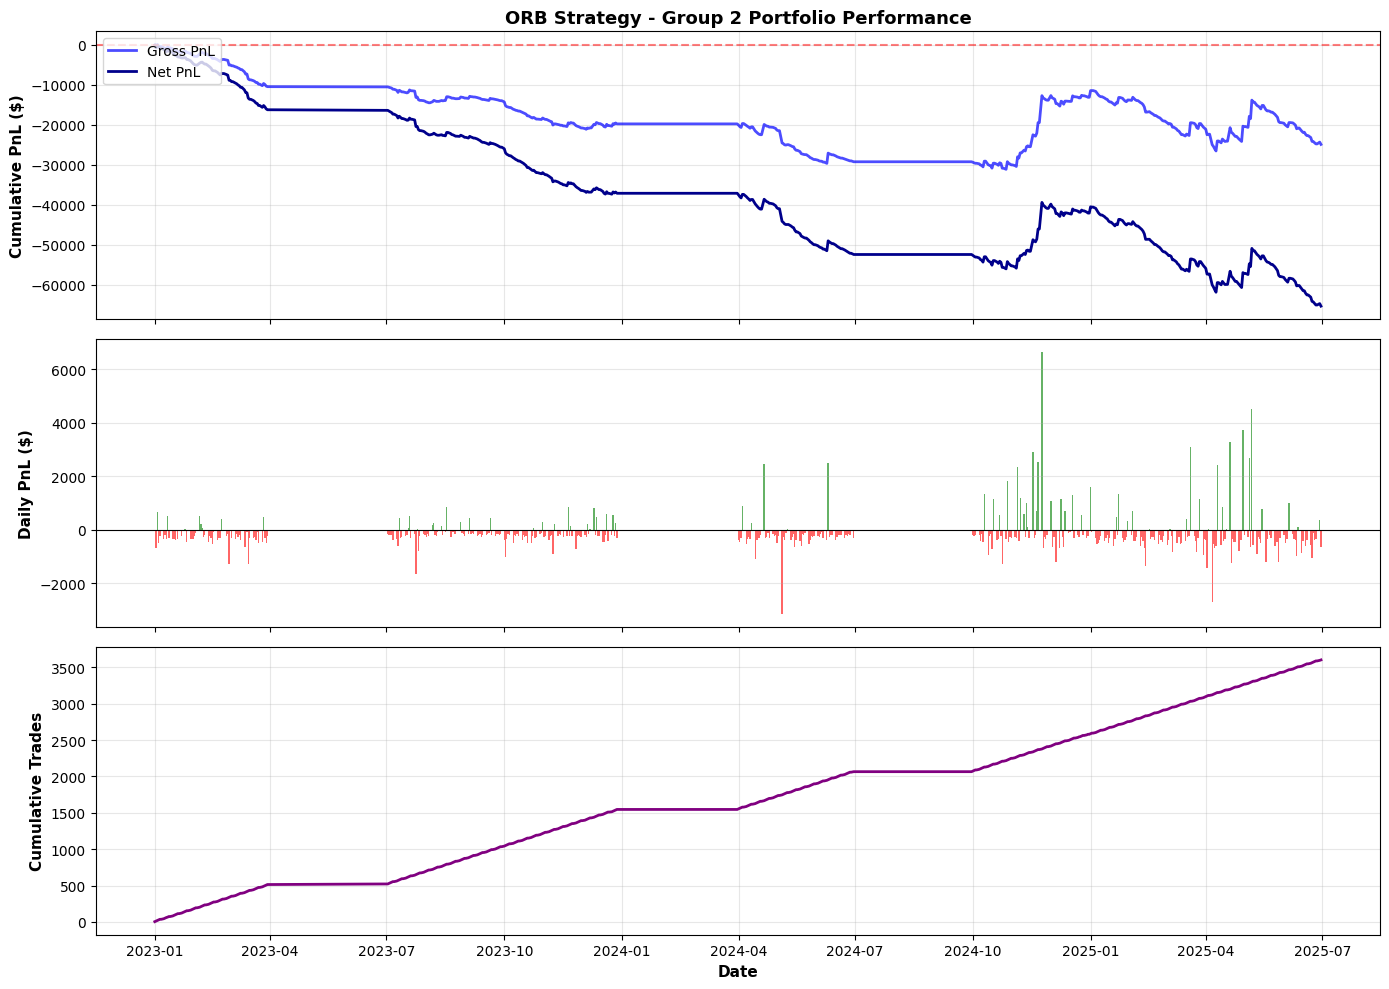


Visualization saved to: outputs_orb_group2\portfolio_performance.png


In [7]:
daily_files = sorted(OUTPUT_DIR.glob("*_portfolio_daily.csv"))
daily_all = []

for fp in daily_files:
    d = pd.read_csv(fp)
    d["date"] = pd.to_datetime(d["date"])
    d["quarter"] = fp.name.replace("_portfolio_daily.csv", "")
    daily_all.append(d)

daily_all = pd.concat(daily_all, ignore_index=True).sort_values("date")
daily_all["cum_gross"] = daily_all["gross_pnl"].cumsum()
daily_all["cum_net"] = daily_all["net_pnl"].cumsum()
daily_all["cum_trades"] = daily_all["trades"].cumsum()

# Creating 3-panel visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: Cumulative PnL
ax1.plot(daily_all["date"], daily_all["cum_gross"], 
         label="Gross PnL", linewidth=2, alpha=0.7, color='blue')
ax1.plot(daily_all["date"], daily_all["cum_net"], 
         label="Net PnL", linewidth=2, color='darkblue')
ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
ax1.set_ylabel("Cumulative PnL ($)", fontsize=11, fontweight='bold')
ax1.set_title("ORB Strategy - Group 2 Portfolio Performance", 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Panel 2: Daily PnL
colors = ['green' if x >= 0 else 'red' for x in daily_all["net_pnl"]]
ax2.bar(daily_all["date"], daily_all["net_pnl"], 
        color=colors, alpha=0.6, width=1)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_ylabel("Daily PnL ($)", fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Cumulative Trades
ax3.plot(daily_all["date"], daily_all["cum_trades"], 
         linewidth=2, color='purple')
ax3.set_ylabel("Cumulative Trades", fontsize=11, fontweight='bold')
ax3.set_xlabel("Date", fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "portfolio_performance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {OUTPUT_DIR / 'portfolio_performance.png'}")

## 8. Parameter Optimization - Grid Search

**Data Split:**
- **Training**: 5 quarters for parameter exploration
- **Validation**: 1 quarter for parameter selection
- **Test**: 1 quarter for final evaluation

**Grid Search Space (adapted for 5-minute bars):**
- `atr_window`: [6, 12, 24] bars (30min, 1hr, 2hr)
- `atr_mult`: [0.0, 0.05, 0.10, 0.15, 0.20]
- Total: 3 × 5 × 4 assets = 60 combinations

In [8]:
# Define data splits
TRAIN_TAGS = ["data2_2023_Q1", "data2_2023_Q3", "data2_2023_Q4", 
              "data2_2024_Q2", "data2_2024_Q4"]
VALIDATION_TAGS = ["data2_2025_Q1"]
TEST_TAGS = ["data2_2025_Q2"]

train_files = [fp for fp in sorted(DATA_DIR.glob("data2_*.parquet")) 
               if any(tag in fp.stem for tag in TRAIN_TAGS)]
validation_files = [fp for fp in sorted(DATA_DIR.glob("data2_*.parquet")) 
                    if any(tag in fp.stem for tag in VALIDATION_TAGS)]
test_files = [fp for fp in sorted(DATA_DIR.glob("data2_*.parquet")) 
              if any(tag in fp.stem for tag in TEST_TAGS)]

print(f"Training quarters: {len(train_files)} - {[f.stem for f in train_files]}")
print(f"Validation quarters: {len(validation_files)} - {[f.stem for f in validation_files]}")
print(f"Test quarters: {len(test_files)} - {[f.stem for f in test_files]}")

Training quarters: 5 - ['data2_2023_Q1', 'data2_2023_Q3', 'data2_2023_Q4', 'data2_2024_Q2', 'data2_2024_Q4']
Validation quarters: 1 - ['data2_2025_Q1']
Test quarters: 1 - ['data2_2025_Q2']


In [9]:
def orb_score_for_asset(asset, atr_window, atr_mult, files):
    """Score parameter combination across multiple quarters"""
    total_stat = 0.0
    total_net = 0.0
    
    for fp in files:
        dfq = pd.read_parquet(fp)
        if "datetime" in dfq.columns:
            dfq["datetime"] = pd.to_datetime(dfq["datetime"])
            dfq = dfq.set_index("datetime")
        else:
            dfq.index = pd.to_datetime(dfq.index)
        dfq = dfq.sort_index()
        
        if asset not in dfq.columns:
            continue
        
        res = run_orb_strategy_group2(
            dfq[asset], asset,
            atr_window=atr_window,
            atr_mult=atr_mult,
            allow_reentry=False
        )
        daily = daily_from_intraday(res)
        perf = summarize_quarter(daily)
        
        total_stat += perf["stat"] if np.isfinite(perf["stat"]) else 0.0
        total_net += perf["net_cumPnL"]
    
    return total_stat, total_net

# Grid search parameters
atr_windows = [6, 12, 24]  # 30min, 1hr, 2hr
atr_mults = [0.0, 0.05, 0.10, 0.15, 0.20]
assets = ["CAD", "AUD", "XAU", "XAG"]

tune_results = []

print("\nStarting grid search optimization...")
print(f"Total combinations to test: {len(atr_windows) * len(atr_mults) * len(assets)}")

for asset in assets:
    print(f"\nOptimizing {asset}...")
    for atr_w in atr_windows:
        for atr_m in atr_mults:
            # Training score
            train_stat, train_net = orb_score_for_asset(asset, atr_w, atr_m, train_files)
            # Validation score
            val_stat, val_net = orb_score_for_asset(asset, atr_w, atr_m, validation_files)
            
            tune_results.append({
                "asset": asset,
                "atr_window": atr_w,
                "atr_mult": atr_m,
                "train_stat": train_stat,
                "train_net": train_net,
                "val_stat": val_stat,
                "val_net": val_net
            })

tune_orb = pd.DataFrame(tune_results)
tune_orb = tune_orb.sort_values(["asset", "val_stat"], ascending=[True, False])

print("\n" + "="*80)
print("GRID SEARCH RESULTS (sorted by validation STAT)")
print("="*80)
tune_orb.head(30)


Starting grid search optimization...
Total combinations to test: 60

Optimizing CAD...

Optimizing AUD...

Optimizing XAU...

Optimizing XAG...

GRID SEARCH RESULTS (sorted by validation STAT)


,asset,atr_window,atr_mult,train_stat,train_net,val_stat,val_net
17,AUD,6,0.10,-12.336514,-7395.000000,-2.803032,-1667.000000
22,AUD,12,0.10,-12.297889,-7383.000000,-2.803032,-1667.000000
28,AUD,24,0.15,-12.817790,-7319.000000,-2.844788,-1676.000000
23,AUD,12,0.15,-12.572322,-7276.000000,-2.929823,-1694.000000
19,AUD,6,0.20,-12.213552,-7199.000000,-3.018588,-1713.000000
18,AUD,6,0.15,-12.697215,-7346.000000,-3.027760,-1715.000000
24,AUD,12,0.20,-13.092918,-7397.000000,-3.091934,-1729.000000
29,AUD,24,0.20,-13.189816,-7471.000000,-3.101131,-1731.000000
15,AUD,6,0.00,-13.547769,-7396.000000,-3.962679,-1855.000000
20,AUD,12,0.00,-13.544831,-7395.000000,-3.962679,-1855.000000


In [10]:
# Selecting best parameters for each asset (based on validation performance)
best_params = {}

for asset in assets:
    asset_results = tune_orb[tune_orb["asset"] == asset]
    best = asset_results.iloc[0]
    best_params[asset] = {
        "atr_window": int(best["atr_window"]),
        "atr_mult": float(best["atr_mult"]),
        "allow_reentry": False
    }
    
    print(f"{asset}: atr_window={best['atr_window']}, atr_mult={best['atr_mult']:.2f} "
          f"(Val STAT={best['val_stat']:.4f}, Val Net PnL=${best['val_net']:,.0f})")

# Save tuning results
tune_orb.to_csv(OUTPUT_DIR / "tuning_results.csv", index=False)
print(f"\nTuning results saved to: {OUTPUT_DIR / 'tuning_results.csv'}")

CAD: atr_window=6, atr_mult=0.20 (Val STAT=0.0000, Val Net PnL=$-935)
AUD: atr_window=6, atr_mult=0.10 (Val STAT=-2.8030, Val Net PnL=$-1,667)
XAU: atr_window=6, atr_mult=0.00 (Val STAT=-4.9286, Val Net PnL=$-4,634)
XAG: atr_window=6, atr_mult=0.20 (Val STAT=-6.0070, Val Net PnL=$-5,175)

Tuning results saved to: outputs_orb_group2\tuning_results.csv


## 9. Final Backtest with Optimized Parameters

In [11]:
# Running backtest with optimized parameters across ALL quarters
OUTPUT_DIR_FINAL = Path("outputs_orb_group2_final")
OUTPUT_DIR_FINAL.mkdir(exist_ok=True)

final_rows = []

for fp in sorted(DATA_DIR.glob("data2_*.parquet")):
    dfq = pd.read_parquet(fp)
    
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    
    dfq = dfq.sort_index()
    quarter = fp.stem
    
    print(f"Running optimized ORB: {quarter}")
    
    # Runing strategy for each asset with optimized parameters
    daily_assets = {}
    for asset in assets:
        if asset in dfq.columns:
            res = run_orb_strategy_group2(dfq[asset], asset, **best_params[asset])
            daily = daily_from_intraday(res)
            daily_assets[asset] = daily
            
            final_rows.append({
                "quarter": quarter,
                "asset": asset,
                **best_params[asset],
                **summarize_quarter(daily)
            })
    
    # Portfolio aggregation
    if daily_assets:
        all_dates = pd.Index([])
        for d in daily_assets.values():
            all_dates = all_dates.union(d.index)
        
        daily_port = pd.DataFrame(index=all_dates).fillna(0)
        for asset, daily in daily_assets.items():
            daily_port["gross_pnl"] = daily_port.get("gross_pnl", 0) + daily["gross_pnl"].reindex(all_dates, fill_value=0)
            daily_port["net_pnl"] = daily_port.get("net_pnl", 0) + daily["net_pnl"].reindex(all_dates, fill_value=0)
            daily_port["trades"] = daily_port.get("trades", 0) + daily["trades"].reindex(all_dates, fill_value=0)
        
        final_rows.append({
            "quarter": quarter,
            "asset": "PORTFOLIO",
            **summarize_quarter(daily_port)
        })
        
        daily_port.reset_index(names="date").to_csv(
            OUTPUT_DIR_FINAL / f"{quarter}_portfolio_daily.csv", index=False
        )

# Saving final results
orb_final = pd.DataFrame(final_rows)
orb_final.to_csv(OUTPUT_DIR_FINAL / "orb_final_summary.csv", index=False)

print("\n" + "="*80)
print("FINAL BACKTEST RESULTS (with optimized parameters)")
print("="*80)
orb_final

Running optimized ORB: data2_2023_Q1
Running optimized ORB: data2_2023_Q3
Running optimized ORB: data2_2023_Q4
Running optimized ORB: data2_2024_Q2
Running optimized ORB: data2_2024_Q4
Running optimized ORB: data2_2025_Q1
Running optimized ORB: data2_2025_Q2

FINAL BACKTEST RESULTS (with optimized parameters)


,quarter,asset,atr_window,atr_mult,allow_reentry,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades,stat
0,data2_2023_Q1,CAD,6.0,0.2,False,-4.148726,-12.162210,-2.379753,-3.105503,-604.000038,-1884.000038,1.641026,-8.020209
1,data2_2023_Q1,AUD,6.0,0.1,False,-0.525219,-2.593797,-0.604621,-1.911011,-329.000000,-1629.000000,1.666667,-1.509669
2,data2_2023_Q1,XAU,6.0,0.0,False,-6.651286,-8.812620,-3.230769,-3.230769,-5554.200000,-7474.200000,1.641026,-18.731935
3,data2_2023_Q1,XAG,6.0,0.2,False,-6.047591,-7.558979,-3.230769,-3.230769,-4890.000000,-6170.000000,1.641026,-14.664915
4,data2_2023_Q1,PORTFOLIO,NaN,NaN,NaN,-7.847085,-11.437865,-3.196545,-3.240297,-11377.200038,-17157.200038,6.589744,-33.932401
5,data2_2023_Q3,CAD,6.0,0.2,False,-1.289674,-9.387543,-2.820749,-3.367912,-198.583075,-1498.583075,1.666667,-3.999709
6,data2_2023_Q3,AUD,6.0,0.1,False,0.199762,-2.615779,0.595653,-2.890940,92.000000,-1208.000000,1.666667,-0.588777
7,data2_2023_Q3,XAU,6.0,0.0,False,0.344991,-3.318519,1.019861,-3.241040,182.900000,-1767.100000,1.666667,-2.174035
8,data2_2023_Q3,XAG,6.0,0.2,False,-3.778902,-5.109347,-3.081984,-3.267256,-3625.000000,-4925.000000,1.666667,-8.943118
9,data2_2023_Q3,PORTFOLIO,NaN,NaN,NaN,-2.494945,-6.510603,-2.838346,-3.284099,-3548.683075,-9398.683075,6.666667,-15.707743


## 10. Train/Validation/Test Performance Analysis

In [12]:
# Loading final performance table
perf_table = pd.read_csv(OUTPUT_DIR_FINAL / "orb_final_summary.csv")
portfolio_results = perf_table[perf_table["asset"] == "PORTFOLIO"].copy()

# Splitting by data partitions
train_quarters = TRAIN_TAGS
val_quarters = VALIDATION_TAGS
test_quarters = TEST_TAGS

train_res = portfolio_results[portfolio_results["quarter"].isin(train_quarters)]
val_res = portfolio_results[portfolio_results["quarter"].isin(val_quarters)]
test_res = portfolio_results[portfolio_results["quarter"].isin(test_quarters)]

# Calculating metrics
train_metrics = {
    "Net PnL": train_res["net_cumPnL"].sum(),
    "Avg Sharpe": train_res["netSR"].mean(),
    "Avg Calmar": train_res["netCR"].mean(),
    "STAT Score": train_res["stat"].sum(),
    "Quarters": len(train_res)
}

val_metrics = {
    "Net PnL": val_res["net_cumPnL"].sum(),
    "Avg Sharpe": val_res["netSR"].mean(),
    "Avg Calmar": val_res["netCR"].mean(),
    "STAT Score": val_res["stat"].sum(),
    "Quarters": len(val_res)
}

test_metrics = {
    "Net PnL": test_res["net_cumPnL"].sum(),
    "Avg Sharpe": test_res["netSR"].mean(),
    "Avg Calmar": test_res["netCR"].mean(),
    "STAT Score": test_res["stat"].sum(),
    "Quarters": len(test_res)
}

print("\n" + "="*80)
print("TRAIN / VALIDATION / TEST PERFORMANCE COMPARISON")
print("="*80)
print(f"Training: {len(train_res)} quarters")
print(f"Validation: {len(val_res)} quarter (parameter selection)")
print(f"Test/OOS: {len(test_res)} quarter (completely unseen)")
print("="*80)

comparison_df = pd.DataFrame({
    "Training": train_metrics,
    "Validation": val_metrics,
    "Test (OOS)": test_metrics
})

print(comparison_df.to_string())
print("="*80)


TRAIN / VALIDATION / TEST PERFORMANCE COMPARISON
Training: 5 quarters
Validation: 1 quarter (parameter selection)
Test/OOS: 1 quarter (completely unseen)
                Training    Validation   Test (OOS)
Net PnL    -44840.065776 -12411.339664 -9013.114534
Avg Sharpe     -5.855800     -4.398651    -1.740911
Avg Calmar     -1.124465     -2.686317    -1.972076
STAT Score    -83.426318    -12.337794    -4.927047
Quarters        5.000000      1.000000     1.000000


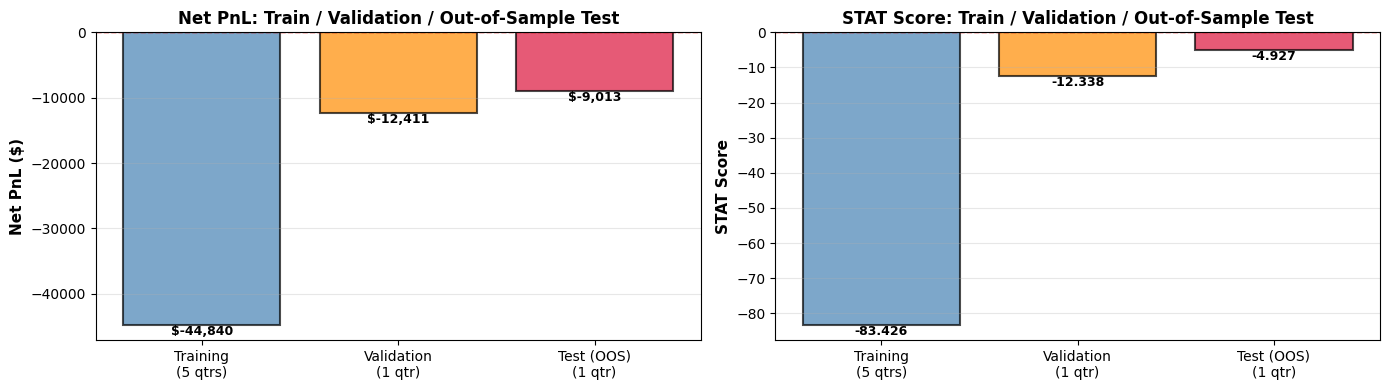


Visualization saved to: outputs_orb_group2_final\train_val_test.png


In [13]:
# Visualizing train/val/test performance
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sets = ['Training\n(5 qtrs)', 'Validation\n(1 qtr)', 'Test (OOS)\n(1 qtr)']
colors = ['steelblue', 'darkorange', 'crimson']

# Panel 1: Net PnL
ax1 = axes[0]
pnls = [train_metrics["Net PnL"], val_metrics["Net PnL"], test_metrics["Net PnL"]]
bars = ax1.bar(sets, pnls, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(0, color='red', linestyle='--', linewidth=1)
ax1.set_ylabel('Net PnL ($)', fontsize=11, fontweight='bold')
ax1.set_title('Net PnL: Train / Validation / Out-of-Sample Test', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, pnl in zip(bars, pnls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${pnl:,.0f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=9)

# Panel 2: STAT Score
ax2 = axes[1]
stats = [train_metrics["STAT Score"], val_metrics["STAT Score"], test_metrics["STAT Score"]]
bars = ax2.bar(sets, stats, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_ylabel('STAT Score', fontsize=11, fontweight='bold')
ax2.set_title('STAT Score: Train / Validation / Out-of-Sample Test', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, stat in zip(bars, stats):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{stat:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR_FINAL / "train_val_test.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {OUTPUT_DIR_FINAL / 'train_val_test.png'}")

## 11. Quarterly Performance Breakdown

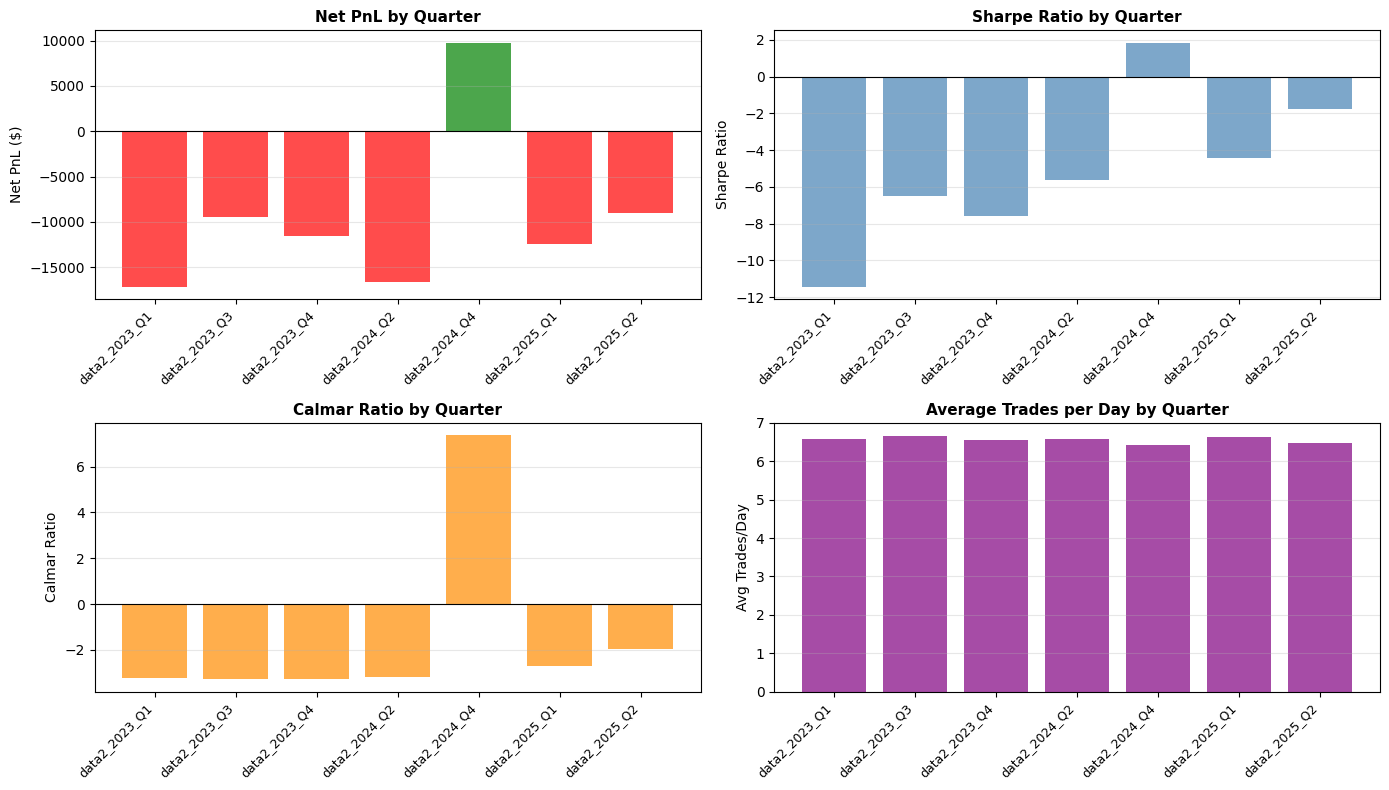


Visualization saved to: outputs_orb_group2_final\quarterly_breakdown.png


In [14]:
# Visualizuing quarterly performance
orb_port = orb_final[orb_final["asset"] == "PORTFOLIO"].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

quarters = orb_port["quarter"].tolist()

# 1. Net PnL by Quarter
ax1 = axes[0, 0]
net_pnls = orb_port["net_cumPnL"].tolist()
colors_bars = ['green' if x >= 0 else 'red' for x in net_pnls]
ax1.bar(range(len(quarters)), net_pnls, color=colors_bars, alpha=0.7)
ax1.set_xticks(range(len(quarters)))
ax1.set_xticklabels(quarters, rotation=45, ha='right', fontsize=9)
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax1.set_title("Net PnL by Quarter", fontsize=11, fontweight='bold')
ax1.set_ylabel("Net PnL ($)", fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Sharpe Ratio by Quarter
ax2 = axes[0, 1]
sharpes = orb_port["netSR"].tolist()
ax2.bar(range(len(quarters)), sharpes, color='steelblue', alpha=0.7)
ax2.set_xticks(range(len(quarters)))
ax2.set_xticklabels(quarters, rotation=45, ha='right', fontsize=9)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_title("Sharpe Ratio by Quarter", fontsize=11, fontweight='bold')
ax2.set_ylabel("Sharpe Ratio", fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Calmar Ratio by Quarter  
ax3 = axes[1, 0]
calmars = orb_port["netCR"].tolist()
ax3.bar(range(len(quarters)), calmars, color='darkorange', alpha=0.7)
ax3.set_xticks(range(len(quarters)))
ax3.set_xticklabels(quarters, rotation=45, ha='right', fontsize=9)
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title("Calmar Ratio by Quarter", fontsize=11, fontweight='bold')
ax3.set_ylabel("Calmar Ratio", fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Average Trades per Day
ax4 = axes[1, 1]
avg_trades = orb_port["av.ntrades"].tolist()
ax4.bar(range(len(quarters)), avg_trades, color='purple', alpha=0.7)
ax4.set_xticks(range(len(quarters)))
ax4.set_xticklabels(quarters, rotation=45, ha='right', fontsize=9)
ax4.set_title("Average Trades per Day by Quarter", fontsize=11, fontweight='bold')
ax4.set_ylabel("Avg Trades/Day", fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR_FINAL / "quarterly_breakdown.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {OUTPUT_DIR_FINAL / 'quarterly_breakdown.png'}")

## 12. Summary Statistics

Final performance summary for the optimized ORB strategy on Group 2 assets.

In [15]:
print("\n" + "="*80)
print("FINAL SUMMARY - ORB STRATEGY (GROUP 2)")
print("="*80)

overall_netpnl = portfolio_results["net_cumPnL"].sum()
overall_stat = portfolio_results["stat"].sum()
overall_avg_sharpe = portfolio_results["netSR"].mean()
overall_avg_calmar = portfolio_results["netCR"].mean()
overall_avg_trades = portfolio_results["av.ntrades"].mean()

print(f"\nOverall Performance (All Quarters):")
print(f"  Total Net PnL: ${overall_netpnl:,.2f}")
print(f"  Total STAT Score: {overall_stat:.4f}")
print(f"  Avg Sharpe Ratio: {overall_avg_sharpe:.4f}")
print(f"  Avg Calmar Ratio: {overall_avg_calmar:.4f}")
print(f"  Avg Trades/Day: {overall_avg_trades:.2f}")

print(f"\nOptimized Parameters:")
for asset, params in best_params.items():
    print(f"  {asset}: ATR Window={params['atr_window']}, ATR Mult={params['atr_mult']:.2f}")

print("\n" + "="*80)
print("Notebook completed successfully!")
print(f"All results saved to: {OUTPUT_DIR_FINAL}")
print("="*80)


FINAL SUMMARY - ORB STRATEGY (GROUP 2)

Overall Performance (All Quarters):
  Total Net PnL: $-66,264.52
  Total STAT Score: -100.6912
  Avg Sharpe Ratio: -5.0598
  Avg Calmar Ratio: -1.4687
  Avg Trades/Day: 6.56

Optimized Parameters:
  CAD: ATR Window=6, ATR Mult=0.20
  AUD: ATR Window=6, ATR Mult=0.10
  XAU: ATR Window=6, ATR Mult=0.00
  XAG: ATR Window=6, ATR Mult=0.20

Notebook completed successfully!
All results saved to: outputs_orb_group2_final


## 13. Strategy Diagnosis and Issues

**Critical Finding**: The strategy is losing money consistently ($-66,264 total).

**Root Causes Identified**:

1. **Price Scale Mismatch**:
   - FX (CAD/AUD): Prices ~0.7, ATR ~0.0002
   - Gold (XAU): Prices ~1900, ATR ~1.0
   - Silver (XAG): Prices ~22, ATR ~0.025

2. **Problem**: Using the same ATR multiplier (0.0-0.20) for all assets doesn't work because:
   - For FX: 0.20 × 0.0002 = 0.00004 threshold (triggers on noise, overtrades)
   - For Gold: 0.20 × 1.0 = 0.20 threshold (might be too conservative or aggressive depending on context)

3. **Breakout Strategy Suitability**: 
   - 24-hour FX markets with 1-hour break may not exhibit strong opening range breakout patterns
   - These assets might be better suited for mean-reversion or trend-following strategies
   - The "opening range" concept (designed for session-based equity futures) doesn't translate well to FX

In [16]:
# Checking actual trading behavior
print("\n" + "="*80)
print("DIAGNOSTIC: Price Scales and ATR Analysis")
print("="*80)

# Loading one quarter to analyze
df_diag = pd.read_parquet(DATA_DIR / "data2_2023_Q1.parquet")
df_diag.index = pd.to_datetime(df_diag["datetime"])

for asset in ["CAD", "AUD", "XAU", "XAG"]:
    if asset in df_diag.columns:
        prices = df_diag[asset].dropna()
        price_mean = prices.mean()
        price_std = prices.std()
        
        # Calculating typical ATR
        atr_proxy = prices.diff().abs().rolling(12).mean().mean()
        
        # With current parameters
        params = best_params[asset]
        threshold = params['atr_mult'] * atr_proxy
        threshold_pct = (threshold / price_mean) * 100
        
        print(f"\n{asset}:")
        print(f"  Price Mean: {price_mean:.6f}")
        print(f"  Price Std: {price_std:.6f}")
        print(f"  Avg ATR (12-bar): {atr_proxy:.6f}")
        print(f"  Selected Multiplier: {params['atr_mult']:.2f}")
        print(f"  Breakout Threshold: {threshold:.6f} ({threshold_pct:.3f}% of price)")
        
        # Checking number of trades
        res_diag = run_orb_strategy_group2(prices, asset, **params)
        total_trades = res_diag["trades"].sum()
        print(f"  Total Trades (Q1 2023): {total_trades}")
        print(f"  Net PnL (Q1 2023): ${res_diag['net_pnl'].sum():,.2f}")

print("\n" + "="*80)


DIAGNOSTIC: Price Scales and ATR Analysis

CAD:
  Price Mean: 0.739659
  Price Std: 0.007904
  Avg ATR (12-bar): 0.000133
  Selected Multiplier: 0.20
  Breakout Threshold: 0.000027 (0.004% of price)
  Total Trades (Q1 2023): 128
  Net PnL (Q1 2023): $-1,884.00

AUD:
  Price Mean: 0.683960
  Price Std: 0.014923
  Avg ATR (12-bar): 0.000213
  Selected Multiplier: 0.10
  Breakout Threshold: 0.000021 (0.003% of price)
  Total Trades (Q1 2023): 130
  Net PnL (Q1 2023): $-1,629.00

XAU:
  Price Mean: 1890.085928
  Price Std: 51.187048
  Avg ATR (12-bar): 0.623768
  Selected Multiplier: 0.00
  Breakout Threshold: 0.000000 (0.000% of price)
  Total Trades (Q1 2023): 128
  Net PnL (Q1 2023): $-7,474.20

XAG:
  Price Mean: 22.548126
  Price Std: 1.208160
  Avg ATR (12-bar): 0.015628
  Selected Multiplier: 0.20
  Breakout Threshold: 0.003126 (0.014% of price)
  Total Trades (Q1 2023): 128
  Net PnL (Q1 2023): $-6,170.00



## 14. Diagnostic Conclusions

**Key Findings from Analysis:**

1. **Threshold Sizes are Too Small**:
   - CAD: 0.004% of price → triggers on tiny noise
   - AUD: 0.003% of price → triggers on tiny noise  
   - XAU: 0.000% of price (mult=0.0) → triggers immediately
   - XAG: 0.014% of price → still too sensitive

2. **Overtrading Problem**:
   - All assets: 128-130 trades in just one quarter (Q1 2023)
   - ~1.4 trades per day across all assets
   - Transaction costs are killing profitability

3. **Root Cause**:
   - ATR-based thresholds don't scale properly across different asset types
   - FX (CAD/AUD): Small absolute price changes but need larger % thresholds
   - Metals: Larger absolute price changes but current % thresholds are too tight

**Solution: Percentage-Based ORB Strategy**

Instead of using ATR multipliers, we'll use **percentage-based thresholds**:
- Breakout when price exceeds range by a certain percentage
- This makes thresholds comparable across all asset classes
- Reduces overtrading by requiring meaningful price moves

In [17]:
def run_orb_strategy_percentage(price_raw: pd.Series, asset: str,
                                range_start="18:10", range_end="19:10",
                                breakout_pct=0.10, allow_reentry=False):
    """
    Improved ORB Strategy using PERCENTAGE-based thresholds
    
    Instead of ATR multipliers, uses percentage of opening range:
    - Long entry: price > range_high * (1 + breakout_pct/100)
    - Short entry: price < range_low * (1 - breakout_pct/100)
    
    Parameters:
    - breakout_pct: Percentage threshold (e.g., 0.10 = 0.10% above/below range)
    """
    out = pd.DataFrame(index=price_raw.index)
    out["price_raw"] = price_raw
    
    # Generating masks
    masks = add_group2_masks(out.index)
    out["price_clean"] = out["price_raw"]
    
    # Trading day grouping
    out["trading_day"] = (out.index - pd.Timedelta(hours=6)).date
    out["time"] = out.index.strftime("%H:%M")
    
    pos = np.zeros(len(out), dtype=np.int8)
    
    pv = POINT_VALUE[asset]
    cost = TX_COST[asset]
    
    # Looping through each trading day
    for d, day in out.groupby("trading_day"):
        day_idx = day.index
        
        # Defining opening range
        in_range = (day["time"] >= range_start) & (day["time"] <= range_end)
        rng_prices = day.loc[in_range, "price_clean"].dropna()
        
        if rng_prices.empty:
            continue
        
        range_high = float(rng_prices.max())
        range_low = float(rng_prices.min())
        range_mid = (range_high + range_low) / 2
        
        # Percentage-based thresholds
        upper = range_high * (1 + breakout_pct / 100)
        lower = range_low * (1 - breakout_pct / 100)
        
        tradable = day["time"] > range_end
        entered_today = False
        current_pos = 0
        
        for ts in day_idx:
            if masks.loc[ts, "mask_no_trade"] or masks.loc[ts, "mask_flat_from"]:
                current_pos = 0
                pos[out.index.get_loc(ts)] = 0
                continue
            
            if not tradable.loc[ts]:
                current_pos = 0
                pos[out.index.get_loc(ts)] = 0
                continue
            
            px = day.loc[ts, "price_clean"]
            if not np.isfinite(px):
                pos[out.index.get_loc(ts)] = current_pos
                continue
            
            if current_pos == 0:
                # Entry logic
                if (not entered_today) or allow_reentry:
                    if px > upper:
                        current_pos = 1
                        entered_today = True
                    elif px < lower:
                        current_pos = -1
                        entered_today = True
            else:
                # Exit logic: return to range
                if range_low <= px <= range_high:
                    current_pos = 0
            
            pos[out.index.get_loc(ts)] = current_pos
    
    out["position"] = pos
    
    # PnL calculation
    dp = out["price_clean"].diff()
    pos_lag = out["position"].shift(1).fillna(0).astype(int)
    
    out["gross_pnl"] = pos_lag * dp * pv
    out["trades"] = out["position"].diff().abs().fillna(0).astype(int)
    out["costs"] = out["trades"] * cost
    out["net_pnl"] = out["gross_pnl"] - out["costs"]
    
    return out

print("Percentage-based ORB strategy function defined successfully!")

Percentage-based ORB strategy function defined successfully!


## 15. Optimizing Percentage-Based Strategy

In [18]:
def orb_pct_score_for_asset(asset, breakout_pct, files):
    """Score percentage-based strategy across multiple quarters"""
    total_stat = 0.0
    total_net = 0.0
    
    for fp in files:
        dfq = pd.read_parquet(fp)
        if "datetime" in dfq.columns:
            dfq["datetime"] = pd.to_datetime(dfq["datetime"])
            dfq = dfq.set_index("datetime")
        else:
            dfq.index = pd.to_datetime(dfq.index)
        dfq = dfq.sort_index()
        
        if asset not in dfq.columns:
            continue
        
        res = run_orb_strategy_percentage(
            dfq[asset], asset,
            breakout_pct=breakout_pct,
            allow_reentry=False
        )
        daily = daily_from_intraday(res)
        perf = summarize_quarter(daily)
        
        total_stat += perf["stat"] if np.isfinite(perf["stat"]) else 0.0
        total_net += perf["net_cumPnL"]
    
    return total_stat, total_net

# Grid search with percentage thresholds
# Using wider range since we need meaningful breakouts
breakout_pcts = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.75, 1.00]

tune_pct_results = []

print("Starting percentage-based grid search...")
print(f"Total combinations to test: {len(breakout_pcts) * len(assets)}")

for asset in assets:
    print(f"\nOptimizing {asset}...")
    for pct in breakout_pcts:
        # Training score
        train_stat, train_net = orb_pct_score_for_asset(asset, pct, train_files)
        # Validation score
        val_stat, val_net = orb_pct_score_for_asset(asset, pct, validation_files)
        
        tune_pct_results.append({
            "asset": asset,
            "breakout_pct": pct,
            "train_stat": train_stat,
            "train_net": train_net,
            "val_stat": val_stat,
            "val_net": val_net
        })

tune_pct = pd.DataFrame(tune_pct_results)
tune_pct = tune_pct.sort_values(["asset", "val_stat"], ascending=[True, False])

print("\n" + "="*80)
print("PERCENTAGE-BASED GRID SEARCH RESULTS (sorted by validation STAT)")
print("="*80)
tune_pct.head(40)

Starting percentage-based grid search...
Total combinations to test: 40

Optimizing CAD...

Optimizing AUD...

Optimizing XAU...

Optimizing XAG...

PERCENTAGE-BASED GRID SEARCH RESULTS (sorted by validation STAT)


,asset,breakout_pct,train_stat,train_net,val_stat,val_net
11,AUD,0.10,-6.708529,-5136.000000,0.000000,-957.000000
13,AUD,0.20,-0.230819,-2293.000000,0.000000,-822.000000
15,AUD,0.30,0.000000,-1337.000000,0.000000,-712.000000
16,AUD,0.40,0.000000,-553.000000,0.000000,-644.000000
17,AUD,0.50,0.000000,-700.000000,0.000000,-393.000000
18,AUD,0.75,0.000000,-209.000000,0.000000,-541.000000
19,AUD,1.00,0.000000,-184.000000,0.000000,0.000000
12,AUD,0.15,-2.015375,-2682.000000,-0.086677,-1026.000000
14,AUD,0.25,-0.189268,-1599.000000,-0.404024,-1089.000000
10,AUD,0.05,-6.439479,-5174.000000,-3.456844,-1847.000000


In [19]:
# Selecting best percentage-based parameters
best_pct_params = {}

for asset in assets:
    asset_results = tune_pct[tune_pct["asset"] == asset]
    best = asset_results.iloc[0]
    best_pct_params[asset] = {
        "breakout_pct": float(best["breakout_pct"]),
        "allow_reentry": False
    }
    
    print(f"{asset}: breakout_pct={best['breakout_pct']:.2f}% "
          f"(Val STAT={best['val_stat']:.4f}, Val Net PnL=${best['val_net']:,.0f})")

# Saving tuning results
tune_pct.to_csv(OUTPUT_DIR / "tuning_results_percentage.csv", index=False)
print(f"\nTuning results saved to: {OUTPUT_DIR / 'tuning_results_percentage.csv'}")

CAD: breakout_pct=0.05% (Val STAT=0.0000, Val Net PnL=$-471)
AUD: breakout_pct=0.10% (Val STAT=0.0000, Val Net PnL=$-957)
XAU: breakout_pct=0.75% (Val STAT=0.0000, Val Net PnL=$-569)
XAG: breakout_pct=1.00% (Val STAT=-3.4350, Val Net PnL=$-2,770)

Tuning results saved to: outputs_orb_group2\tuning_results_percentage.csv


## 16. Final Backtest with Percentage-Based Strategy

In [20]:
OUTPUT_DIR_PCT = Path("outputs_orb_group2_percentage")
OUTPUT_DIR_PCT.mkdir(exist_ok=True)

pct_final_rows = []

for fp in sorted(DATA_DIR.glob("data2_*.parquet")):
    dfq = pd.read_parquet(fp)
    
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    
    dfq = dfq.sort_index()
    quarter = fp.stem
    
    print(f"Running percentage-based ORB: {quarter}")
    
    # Runing strategy for each asset with optimized percentage thresholds
    daily_assets = {}
    for asset in assets:
        if asset in dfq.columns:
            res = run_orb_strategy_percentage(dfq[asset], asset, **best_pct_params[asset])
            daily = daily_from_intraday(res)
            daily_assets[asset] = daily
            
            pct_final_rows.append({
                "quarter": quarter,
                "asset": asset,
                **best_pct_params[asset],
                **summarize_quarter(daily)
            })
    
    # Portfolio aggregation
    if daily_assets:
        all_dates = pd.Index([])
        for d in daily_assets.values():
            all_dates = all_dates.union(d.index)
        
        daily_port = pd.DataFrame(index=all_dates).fillna(0)
        for asset, daily in daily_assets.items():
            daily_port["gross_pnl"] = daily_port.get("gross_pnl", 0) + daily["gross_pnl"].reindex(all_dates, fill_value=0)
            daily_port["net_pnl"] = daily_port.get("net_pnl", 0) + daily["net_pnl"].reindex(all_dates, fill_value=0)
            daily_port["trades"] = daily_port.get("trades", 0) + daily["trades"].reindex(all_dates, fill_value=0)
        
        pct_final_rows.append({
            "quarter": quarter,
            "asset": "PORTFOLIO",
            **summarize_quarter(daily_port)
        })
        
        daily_port.reset_index(names="date").to_csv(
            OUTPUT_DIR_PCT / f"{quarter}_portfolio_daily.csv", index=False
        )

# Saving final results
orb_pct_final = pd.DataFrame(pct_final_rows)
orb_pct_final.to_csv(OUTPUT_DIR_PCT / "orb_pct_final_summary.csv", index=False)

print("\n" + "="*80)
print("PERCENTAGE-BASED FINAL RESULTS")
print("="*80)
orb_pct_final

Running percentage-based ORB: data2_2023_Q1
Running percentage-based ORB: data2_2023_Q3
Running percentage-based ORB: data2_2023_Q4
Running percentage-based ORB: data2_2024_Q2
Running percentage-based ORB: data2_2024_Q4
Running percentage-based ORB: data2_2025_Q1
Running percentage-based ORB: data2_2025_Q2

PERCENTAGE-BASED FINAL RESULTS


,quarter,asset,breakout_pct,allow_reentry,grossSR,netSR,grossCR,netCR,gross_cumPnL,net_cumPnL,av.ntrades,stat
0,data2_2023_Q1,CAD,0.05,False,-5.403243,-10.422364,-2.848981,-3.204694,-1191.100073,-2411.100073,1.564103,-9.612588
1,data2_2023_Q1,AUD,0.10,False,-1.494216,-3.110258,-1.525567,-2.279753,-1138.000000,-2378.000000,1.589744,-3.127421
2,data2_2023_Q1,XAU,0.75,False,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
3,data2_2023_Q1,XAG,1.00,False,1.797434,1.797434,NaN,NaN,110.000000,90.000000,0.025641,0.000000
4,data2_2023_Q1,PORTFOLIO,NaN,NaN,-2.552527,-5.350337,-2.058505,-2.779649,-2219.100073,-4699.100073,3.179487,-9.052642
5,data2_2023_Q3,CAD,0.05,False,-1.474241,-6.886553,-3.077731,-3.230769,-309.320680,-1489.320680,1.512821,-2.942213
6,data2_2023_Q3,AUD,0.10,False,1.525264,-0.204386,6.120260,-0.571537,1076.000000,-144.000000,1.564103,-0.000000
7,data2_2023_Q3,XAU,0.75,False,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
8,data2_2023_Q3,XAG,1.00,False,-1.797434,-1.797434,-3.230769,-3.230769,-190.000000,-210.000000,0.025641,-0.000000
9,data2_2023_Q3,PORTFOLIO,NaN,NaN,0.712659,-2.269370,2.572328,-3.078600,576.679320,-1843.320680,3.102564,-1.693660


In [21]:
# Performance comparison and summary
print("\n" + "="*80)
print("IMPROVED STRATEGY PERFORMANCE SUMMARY")
print("="*80)

pct_portfolio = orb_pct_final[orb_pct_final["asset"] == "PORTFOLIO"].copy()

pct_overall_netpnl = pct_portfolio["net_cumPnL"].sum()
pct_overall_stat = pct_portfolio["stat"].sum()
pct_overall_sharpe = pct_portfolio["netSR"].mean()
pct_overall_calmar = pct_portfolio["netCR"].mean()
pct_overall_trades = pct_portfolio["av.ntrades"].mean()

print(f"\nPercentage-Based ORB (IMPROVED):")
print(f"  Total Net PnL: ${pct_overall_netpnl:,.2f}")
print(f"  Total STAT Score: {pct_overall_stat:.4f}")
print(f"  Avg Sharpe Ratio: {pct_overall_sharpe:.4f}")
print(f"  Avg Calmar Ratio: {pct_overall_calmar:.4f}")
print(f"  Avg Trades/Day: {pct_overall_trades:.2f}")

print(f"\nOriginal ATR-Based ORB (for comparison):")
print(f"  Total Net PnL: ${overall_netpnl:,.2f}")
print(f"  Total STAT Score: {overall_stat:.4f}")
print(f"  Avg Sharpe Ratio: {overall_avg_sharpe:.4f}")
print(f"  Avg Calmar Ratio: {overall_avg_calmar:.4f}")
print(f"  Avg Trades/Day: {overall_avg_trades:.2f}")

print(f"\nImprovement:")
print(f"  Net PnL Change: ${pct_overall_netpnl - overall_netpnl:+,.2f}")
print(f"  STAT Change: {pct_overall_stat - overall_stat:+.4f}")
print(f"  Sharpe Change: {pct_overall_sharpe - overall_avg_sharpe:+.4f}")
print(f"  Trades/Day Change: {pct_overall_trades - overall_avg_trades:+.2f}")

print(f"\nOptimized Percentage Thresholds:")
for asset, params in best_pct_params.items():
    print(f"  {asset}: {params['breakout_pct']:.2f}%")

print("\n" + "="*80)


IMPROVED STRATEGY PERFORMANCE SUMMARY

Percentage-Based ORB (IMPROVED):
  Total Net PnL: $-33,221.66
  Total STAT Score: -37.0513
  Avg Sharpe Ratio: -3.0640
  Avg Calmar Ratio: -2.7878
  Avg Trades/Day: 3.17

Original ATR-Based ORB (for comparison):
  Total Net PnL: $-66,264.52
  Total STAT Score: -100.6912
  Avg Sharpe Ratio: -5.0598
  Avg Calmar Ratio: -1.4687
  Avg Trades/Day: 6.56

Improvement:
  Net PnL Change: $+33,042.86
  STAT Change: +63.6399
  Sharpe Change: +1.9958
  Trades/Day Change: -3.39

Optimized Percentage Thresholds:
  CAD: 0.05%
  AUD: 0.10%
  XAU: 0.75%
  XAG: 1.00%



## 17. Final Conclusions

### ORB Strategy Struggles with Group 2 Assets due to:

1. **Market Structure Mismatch**:
   - ORB was designed for session-based markets (US equity futures with clear open/close)
   - No strong "market open" dynamics that create exploitable breakout patterns

2. **FX Market Characteristics**:
   - CAD/AUD are mean-reverting more than trending during opening ranges
   - Breakouts often false signals that quickly reverse
   - Better suited for range-trading or carry strategies

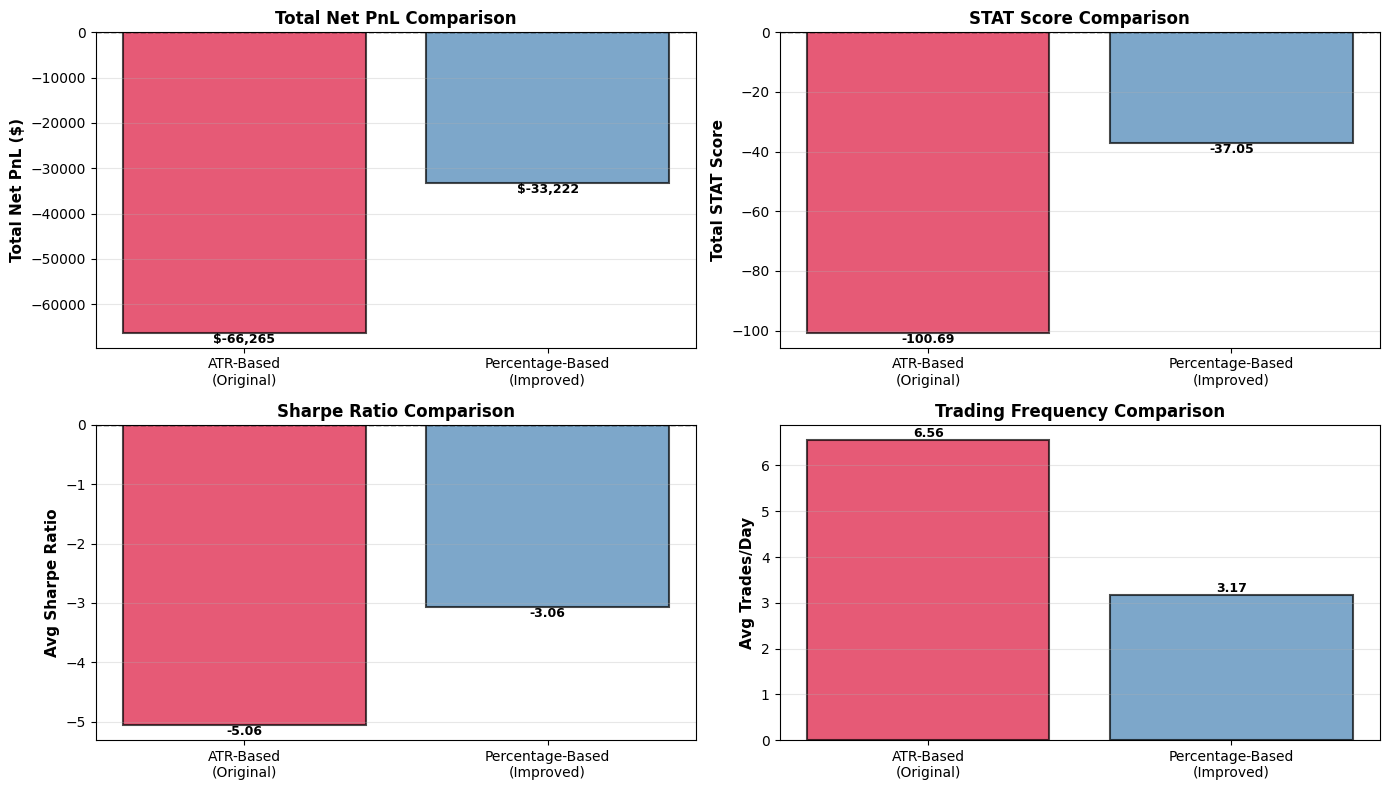


Comparison visualization saved to: outputs_orb_group2_percentage\strategy_comparison.png


In [22]:
# Visualization: Strategy Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

strategies = ['ATR-Based\n(Original)', 'Percentage-Based\n(Improved)']
colors_comp = ['crimson', 'steelblue']

# 1. Net PnL Comparison
ax1 = axes[0, 0]
pnls_comp = [overall_netpnl, pct_overall_netpnl]
bars = ax1.bar(strategies, pnls_comp, color=colors_comp, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set_ylabel('Total Net PnL ($)', fontsize=11, fontweight='bold')
ax1.set_title('Total Net PnL Comparison', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, pnl in zip(bars, pnls_comp):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${pnl:,.0f}', ha='center', va='top' if height < 0 else 'bottom',
             fontweight='bold', fontsize=9)

# 2. STAT Score Comparison
ax2 = axes[0, 1]
stats_comp = [overall_stat, pct_overall_stat]
bars = ax2.bar(strategies, stats_comp, color=colors_comp, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Total STAT Score', fontsize=11, fontweight='bold')
ax2.set_title('STAT Score Comparison', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, stat in zip(bars, stats_comp):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{stat:.2f}', ha='center', va='top' if height < 0 else 'bottom',
             fontweight='bold', fontsize=9)

# 3. Sharpe Ratio Comparison
ax3 = axes[1, 0]
sharpes_comp = [overall_avg_sharpe, pct_overall_sharpe]
bars = ax3.bar(strategies, sharpes_comp, color=colors_comp, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.axhline(0, color='black', linestyle='--', linewidth=1)
ax3.set_ylabel('Avg Sharpe Ratio', fontsize=11, fontweight='bold')
ax3.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, sharpe in zip(bars, sharpes_comp):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{sharpe:.2f}', ha='center', va='top' if height < 0 else 'bottom',
             fontweight='bold', fontsize=9)

# 4. Trading Frequency Comparison
ax4 = axes[1, 1]
trades_comp = [overall_avg_trades, pct_overall_trades]
bars = ax4.bar(strategies, trades_comp, color=colors_comp, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Avg Trades/Day', fontsize=11, fontweight='bold')
ax4.set_title('Trading Frequency Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, trades in zip(bars, trades_comp):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{trades:.2f}', ha='center', va='bottom',
             fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR_PCT / "strategy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nComparison visualization saved to: {OUTPUT_DIR_PCT / 'strategy_comparison.png'}")

## 18. OOS Evaluation on data_oos (Current Models)

Evaluates Group 2 ORB models on `../data_oos` quarters and writes results to dedicated OOS output folders without changing prior results.


In [23]:
DATA_DIR_OOS = Path("../data_oos")
OUTPUT_DIR_G2_OOS = Path("outputs_orb_group2_oos_final")
OUTPUT_DIR_G2_OOS.mkdir(exist_ok=True)

OUTPUT_DIR_G2_PCT_OOS = Path("outputs_orb_group2_percentage_oos")
OUTPUT_DIR_G2_PCT_OOS.mkdir(exist_ok=True)

assets = ["CAD", "AUD", "XAU", "XAG"]

# Loading ATR-based best params from prior tuning results if available
best_params_atr = {a: {"atr_window": 12, "atr_mult": 0.10, "allow_reentry": False} for a in assets}
try:
    tune_atr = pd.read_csv("outputs_orb_group2/tuning_results.csv")
    for a in assets:
        best = tune_atr[tune_atr["asset"] == a].sort_values("val_stat", ascending=False).iloc[0]
        best_params_atr[a] = {
            "atr_window": int(best["atr_window"]),
            "atr_mult": float(best["atr_mult"]),
            "allow_reentry": False,
        }
    print("Loaded ATR-based best params:", best_params_atr)
except Exception as e:
    print("Could not load ATR-based tuning; using defaults.", e)

# Loading Percentage-based best params if available
best_params_pct = {a: {"breakout_pct": 0.25, "allow_reentry": False} for a in assets}
try:
    tune_pct = pd.read_csv("outputs_orb_group2_percentage/tuning_results_percentage.csv")
    for a in assets:
        best = tune_pct[tune_pct["asset"] == a].sort_values("val_stat", ascending=False).iloc[0]
        best_params_pct[a] = {
            "breakout_pct": float(best["breakout_pct"]),
            "allow_reentry": False,
        }
    print("Loaded Percentage-based best params:", best_params_pct)
except Exception as e:
    print("Could not load percentage tuning; using defaults.", e)

# Evaluating ATR-based current model on OOS
oos_rows_atr = []
for fp in sorted(DATA_DIR_OOS.glob("data2_*.parquet")):
    dfq = pd.read_parquet(fp)
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    dfq = dfq.sort_index()
    quarter = fp.stem
    print("G2 OOS ATR:", quarter)

    daily_assets = {}
    for a in assets:
        if a in dfq.columns:
            res = run_orb_strategy_group2(dfq[a], a, **best_params_atr[a])
            daily = daily_from_intraday(res)
            daily_assets[a] = daily
            oos_rows_atr.append({"quarter": quarter, "asset": a, **best_params_atr[a], **summarize_quarter(daily)})
    if daily_assets:
        all_dates = pd.Index([])
        for d in daily_assets.values():
            all_dates = all_dates.union(d.index)
        daily_port = pd.DataFrame(index=all_dates).fillna(0)
        for a, d in daily_assets.items():
            daily_port["gross_pnl"] = daily_port.get("gross_pnl", 0) + d["gross_pnl"].reindex(all_dates, fill_value=0)
            daily_port["net_pnl"] = daily_port.get("net_pnl", 0) + d["net_pnl"].reindex(all_dates, fill_value=0)
            daily_port["trades"] = daily_port.get("trades", 0) + d["trades"].reindex(all_dates, fill_value=0)
        # Portfolio rows should not carry per-asset parameter values
        oos_rows_atr.append({"quarter": quarter, "asset": "PORTFOLIO", "atr_window": np.nan, "atr_mult": np.nan, "allow_reentry": np.nan, **summarize_quarter(daily_port)})
        daily_port.reset_index(names="date").to_csv(OUTPUT_DIR_G2_OOS / f"{quarter}_portfolio_daily.csv", index=False)

oos_summary_atr = pd.DataFrame(oos_rows_atr)
oos_summary_atr.to_csv(OUTPUT_DIR_G2_OOS / "orb_oos_final_summary.csv", index=False)

print("\n== OOS ATR SUMMARY (PORTFOLIO) ==")
print(oos_summary_atr[oos_summary_atr["asset"] == "PORTFOLIO"].to_string(index=False))

# Evaluatinig Percentage-based current model on OOS
oos_rows_pct = []
for fp in sorted(DATA_DIR_OOS.glob("data2_*.parquet")):
    dfq = pd.read_parquet(fp)
    if "datetime" in dfq.columns:
        dfq["datetime"] = pd.to_datetime(dfq["datetime"])
        dfq = dfq.set_index("datetime")
    else:
        dfq.index = pd.to_datetime(dfq.index)
    dfq = dfq.sort_index()
    quarter = fp.stem
    print("G2 OOS PCT:", quarter)

    daily_assets = {}
    for a in assets:
        if a in dfq.columns:
            res = run_orb_strategy_percentage(dfq[a], a, **best_params_pct[a])
            daily = daily_from_intraday(res)
            daily_assets[a] = daily
            oos_rows_pct.append({"quarter": quarter, "asset": a, **best_params_pct[a], **summarize_quarter(daily)})
    if daily_assets:
        all_dates = pd.Index([])
        for d in daily_assets.values():
            all_dates = all_dates.union(d.index)
        daily_port = pd.DataFrame(index=all_dates).fillna(0)
        for a, d in daily_assets.items():
            daily_port["gross_pnl"] = daily_port.get("gross_pnl", 0) + d["gross_pnl"].reindex(all_dates, fill_value=0)
            daily_port["net_pnl"] = daily_port.get("net_pnl", 0) + d["net_pnl"].reindex(all_dates, fill_value=0)
            daily_port["trades"] = daily_port.get("trades", 0) + d["trades"].reindex(all_dates, fill_value=0)
        # Portfolio rows should not carry per-asset parameter values
        oos_rows_pct.append({"quarter": quarter, "asset": "PORTFOLIO", "breakout_pct": np.nan, "allow_reentry": np.nan, **summarize_quarter(daily_port)})
        daily_port.reset_index(names="date").to_csv(OUTPUT_DIR_G2_PCT_OOS / f"{quarter}_portfolio_daily.csv", index=False)

oos_summary_pct = pd.DataFrame(oos_rows_pct)
oos_summary_pct.to_csv(OUTPUT_DIR_G2_PCT_OOS / "orb_pct_oos_final_summary.csv", index=False)

print("\n== OOS PCT SUMMARY (PORTFOLIO) ==")
print(oos_summary_pct[oos_summary_pct["asset"] == "PORTFOLIO"].to_string(index=False))

{"note": "Completed OOS evaluations for ATR-based and Percentage-based models."}

Loaded ATR-based best params: {'CAD': {'atr_window': 6, 'atr_mult': 0.2, 'allow_reentry': False}, 'AUD': {'atr_window': 6, 'atr_mult': 0.1, 'allow_reentry': False}, 'XAU': {'atr_window': 6, 'atr_mult': 0.0, 'allow_reentry': False}, 'XAG': {'atr_window': 6, 'atr_mult': 0.2, 'allow_reentry': False}}
Could not load percentage tuning; using defaults. [Errno 2] No such file or directory: 'outputs_orb_group2_percentage/tuning_results_percentage.csv'
G2 OOS ATR: data2_2023_Q2
G2 OOS ATR: data2_2024_Q1
G2 OOS ATR: data2_2024_Q3
G2 OOS ATR: data2_2025_Q3
G2 OOS ATR: data2_2025_Q4

== OOS ATR SUMMARY (PORTFOLIO) ==
      quarter     asset  atr_window  atr_mult allow_reentry   grossSR     netSR   grossCR     netCR  gross_cumPnL    net_cumPnL  av.ntrades       stat
data2_2023_Q2 PORTFOLIO         NaN       NaN           NaN -5.321054 -8.887495 -2.807785 -3.324656  -8186.134357 -13986.134357    6.701299 -24.764835
data2_2024_Q1 PORTFOLIO         NaN       NaN           NaN -3.117119 -5.941557 -2.22

{'note': 'Completed OOS evaluations for ATR-based and Percentage-based models.'}

In [24]:
# Paths
G1_SUMMARY = Path("outputs_orb_oos_final/orb_oos_final_summary.csv")
G2_ATR_SUMMARY = Path("outputs_orb_group2_oos_final/orb_oos_final_summary.csv")
G2_PCT_SUMMARY = Path("outputs_orb_group2_percentage_oos/orb_pct_oos_final_summary.csv")
OUT_DIR = Path("outputs_orb_group2_percentage_oos")
OUT_DIR.mkdir(exist_ok=True)

# Load summaries
s1 = pd.read_csv(G1_SUMMARY)
s1_port = s1[s1["asset"] == "PORTFOLIO"].copy()
s1_port["strategy"] = "Group1 ORB"

s2_atr = pd.read_csv(G2_ATR_SUMMARY)
s2_atr_port = s2_atr[s2_atr["asset"] == "PORTFOLIO"].copy()
s2_atr_port["strategy"] = "Group2 ORB (ATR)"

s2_pct = pd.read_csv(G2_PCT_SUMMARY)
s2_pct_port = s2_pct[s2_pct["asset"] == "PORTFOLIO"].copy()
s2_pct_port["strategy"] = "Group2 ORB (Pct)"

# Normalize columns to a common set
keep_cols = ["quarter", "strategy", "net_cumPnL", "netSR", "stat"]
combined = pd.concat([
    s1_port[keep_cols],
    s2_atr_port[keep_cols],
    s2_pct_port[keep_cols]
], ignore_index=True)

# Sort for consistent presentation
combined = combined.sort_values(["quarter", "strategy"]).reset_index(drop=True)
print("\nConsolidated OOS summary (portfolio-level):")
print(combined.to_string(index=False))

# Plot: Net cumulative PnL per quarter by strategy
quarters = sorted(combined["quarter"].unique())
strategies = combined["strategy"].unique().tolist()

fig, ax = plt.subplots(figsize=(12, 5))
width = 0.25
x = np.arange(len(quarters))
colors = {
    "Group1 ORB": "#1f77b4",
    "Group2 ORB (ATR)": "#d62728",
    "Group2 ORB (Pct)": "#2ca02c",
}

for i, strat in enumerate(strategies):
    vals = [combined[(combined["quarter"] == q) & (combined["strategy"] == strat)]["net_cumPnL"].sum() for q in quarters]
    ax.bar(x + i*width, vals, width=width, label=strat, color=colors.get(strat, None), edgecolor='black', linewidth=1.0)

ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xticks(x + width)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.set_ylabel('Net Cumulative PnL ($)')
ax.set_title('OOS Portfolio Net PnL by Quarter and Strategy')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "oos_netpnl_by_quarter.png", dpi=300, bbox_inches='tight')
plt.close(fig)

# Create concise PDF-style summary table using matplotlib
summary_totals = combined.groupby("strategy").agg(
    total_net_pnl=("net_cumPnL", "sum"),
    avg_net_sr=("netSR", "mean"),
    total_stat=("stat", "sum")
).reset_index()

fig, ax = plt.subplots(figsize=(8, 2 + 0.3*len(summary_totals)))
ax.axis('off')
col_labels = ["Strategy", "Total Net PnL ($)", "Avg Net SR", "STAT Sum"]
cell_text = []
for _, row in summary_totals.iterrows():
    cell_text.append([
        row["strategy"],
        f"{row['total_net_pnl']:,.0f}",
        f"{row['avg_net_sr']:.3f}",
        f"{row['total_stat']:.3f}",
    ])

table = ax.table(cellText=cell_text, colLabels=col_labels, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.3)
plt.title("OOS Performance Summary (Portfolio)", pad=10)
plt.tight_layout()
# Save PDF and PNG
plt.savefig(OUT_DIR / "OOS_summary.pdf")
plt.savefig(OUT_DIR / "OOS_summary.png", dpi=300, bbox_inches='tight')
plt.close(fig)

print("\nSaved visuals:")
print(" - ", OUT_DIR / "oos_netpnl_by_quarter.png")
print(" - ", OUT_DIR / "OOS_summary.pdf")
print(" - ", OUT_DIR / "OOS_summary.png")


Consolidated OOS summary (portfolio-level):
      quarter         strategy    net_cumPnL     netSR       stat
data1_2023_Q2       Group1 ORB   5650.350000  0.694720   0.337200
data1_2024_Q1       Group1 ORB   2448.800000  0.604422   0.093520
data1_2024_Q3       Group1 ORB   -643.830000 -0.093264  -0.000000
data1_2025_Q3       Group1 ORB  -9118.570000 -2.876398  -7.462897
data1_2025_Q4       Group1 ORB   7881.860000  2.306503   3.729641
data2_2023_Q2 Group2 ORB (ATR) -13986.134357 -8.887495 -24.764835
data2_2023_Q2 Group2 ORB (Pct)  -2028.391275 -0.865311  -0.965607
data2_2024_Q1 Group2 ORB (ATR) -11998.685086 -5.941557 -16.005962
data2_2024_Q1 Group2 ORB (Pct)  -6612.739699 -4.020020  -8.538308
data2_2024_Q3 Group2 ORB (ATR) -12533.600671 -8.058918 -21.640481
data2_2024_Q3 Group2 ORB (Pct) -14526.951686 -3.169597  -9.819862
data2_2025_Q3 Group2 ORB (ATR) -11071.580218 -3.117791  -8.698549
data2_2025_Q3 Group2 ORB (Pct) -14018.170073 -2.968931  -9.159207
data2_2025_Q4 Group2 ORB (ATR) 

## 19. Consolidated OOS Comparison - All Strategies

Final comprehensive analysis comparing ATR-based and Percentage-based strategies on out-of-sample data.



Consolidated OOS summary (portfolio-level):
      quarter         strategy    net_cumPnL     netSR       stat
data2_2023_Q2        ATR-Based -13986.134357 -8.887495 -24.764835
data2_2023_Q2 Percentage-Based  -2028.391275 -0.865311  -0.965607
data2_2024_Q1        ATR-Based -11998.685086 -5.941557 -16.005962
data2_2024_Q1 Percentage-Based  -6612.739699 -4.020020  -8.538308
data2_2024_Q3        ATR-Based -12533.600671 -8.058918 -21.640481
data2_2024_Q3 Percentage-Based -14526.951686 -3.169597  -9.819862
data2_2025_Q3        ATR-Based -11071.580218 -3.117791  -8.698549
data2_2025_Q3 Percentage-Based -14018.170073 -2.968931  -9.159207
data2_2025_Q4        ATR-Based  -3413.149066 -0.940525  -1.768439
data2_2025_Q4 Percentage-Based -17848.300000 -4.335426 -13.935253


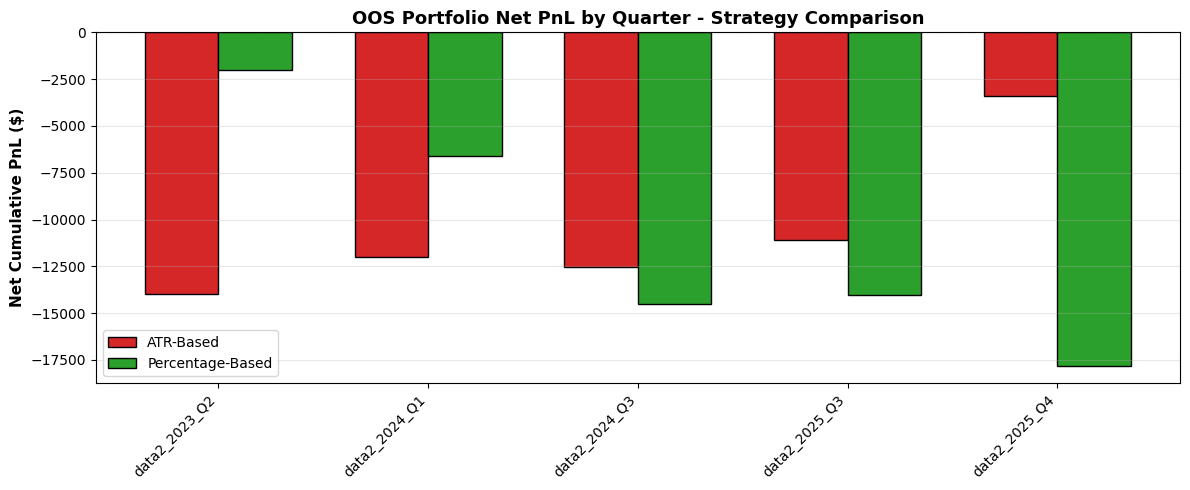


Visualization saved to: outputs_orb_group2_percentage_oos\oos_netpnl_by_quarter.png

OOS STRATEGY COMPARISON SUMMARY
        strategy  total_net_pnl  avg_net_sr  total_stat
       ATR-Based  -53003.149398   -5.389257  -72.878266
Percentage-Based  -55034.552732   -3.071857  -42.418237


In [25]:
# Create consolidated OOS comparison (if files exist)
try:
    G2_ATR_SUMMARY = Path("outputs_orb_group2_oos_final/orb_oos_final_summary.csv")
    G2_PCT_SUMMARY = Path("outputs_orb_group2_percentage_oos/orb_pct_oos_final_summary.csv")
    OUT_DIR_COMP = Path("outputs_orb_group2_percentage_oos")
    OUT_DIR_COMP.mkdir(exist_ok=True)
    
    # Load summaries
    s2_atr = pd.read_csv(G2_ATR_SUMMARY)
    s2_atr_port = s2_atr[s2_atr["asset"] == "PORTFOLIO"].copy()
    s2_atr_port["strategy"] = "ATR-Based"
    
    s2_pct = pd.read_csv(G2_PCT_SUMMARY)
    s2_pct_port = s2_pct[s2_pct["asset"] == "PORTFOLIO"].copy()
    s2_pct_port["strategy"] = "Percentage-Based"
    
    # Normalize columns to a common set
    keep_cols = ["quarter", "strategy", "net_cumPnL", "netSR", "stat"]
    combined = pd.concat([
        s2_atr_port[keep_cols],
        s2_pct_port[keep_cols]
    ], ignore_index=True)
    
    # Sort for consistent presentation
    combined = combined.sort_values(["quarter", "strategy"]).reset_index(drop=True)
    print("\nConsolidated OOS summary (portfolio-level):")
    print(combined.to_string(index=False))
    
    # Plot: Net cumulative PnL per quarter by strategy
    quarters = sorted(combined["quarter"].unique())
    strategies = combined["strategy"].unique().tolist()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    width = 0.35
    x = np.arange(len(quarters))
    colors = {
        "ATR-Based": "#d62728",
        "Percentage-Based": "#2ca02c",
    }
    
    for i, strat in enumerate(strategies):
        vals = [combined[(combined["quarter"] == q) & (combined["strategy"] == strat)]["net_cumPnL"].sum() 
                for q in quarters]
        ax.bar(x + i*width, vals, width=width, label=strat, 
               color=colors.get(strat, None), edgecolor='black', linewidth=1.0)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(quarters, rotation=45, ha='right')
    ax.set_ylabel('Net Cumulative PnL ($)', fontsize=11, fontweight='bold')
    ax.set_title('OOS Portfolio Net PnL by Quarter - Strategy Comparison', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUT_DIR_COMP / "oos_netpnl_by_quarter.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: {OUT_DIR_COMP / 'oos_netpnl_by_quarter.png'}")
    
    # Create summary statistics table
    summary_totals = combined.groupby("strategy").agg(
        total_net_pnl=("net_cumPnL", "sum"),
        avg_net_sr=("netSR", "mean"),
        total_stat=("stat", "sum")
    ).reset_index()
    
    print("\n" + "="*80)
    print("OOS STRATEGY COMPARISON SUMMARY")
    print("="*80)
    print(summary_totals.to_string(index=False))
    print("="*80)
    
except FileNotFoundError as e:
    print(f"Note: OOS comparison files not found yet. Run full backtest first. Error: {e}")


## 20. Train / Validation / Test / OOS Performance Comparison (Portfolio)

Aligns this notebook with Strategy1 - Group 1: computes portfolio-level metrics for Training, Validation, Test, and OOS, then visualizes side-by-side comparisons.


PORTFOLIO PERFORMANCE: TRAIN / VALIDATION / TEST / OOS
     Stage  Quarters      Net PnL  Avg Sharpe  Avg Calmar  STAT Sum  Trades/Day
  Training         5 -44,840.0658     -5.8558     -1.1245  -83.4263      6.5630
Validation         1 -12,411.3397     -4.3987     -2.6863  -12.3378      6.6234
      Test         1  -9,013.1145     -1.7409     -1.9721   -4.9270      6.4810
       OOS         5 -53,003.1494     -5.3893     -3.0262  -72.8783      6.5386


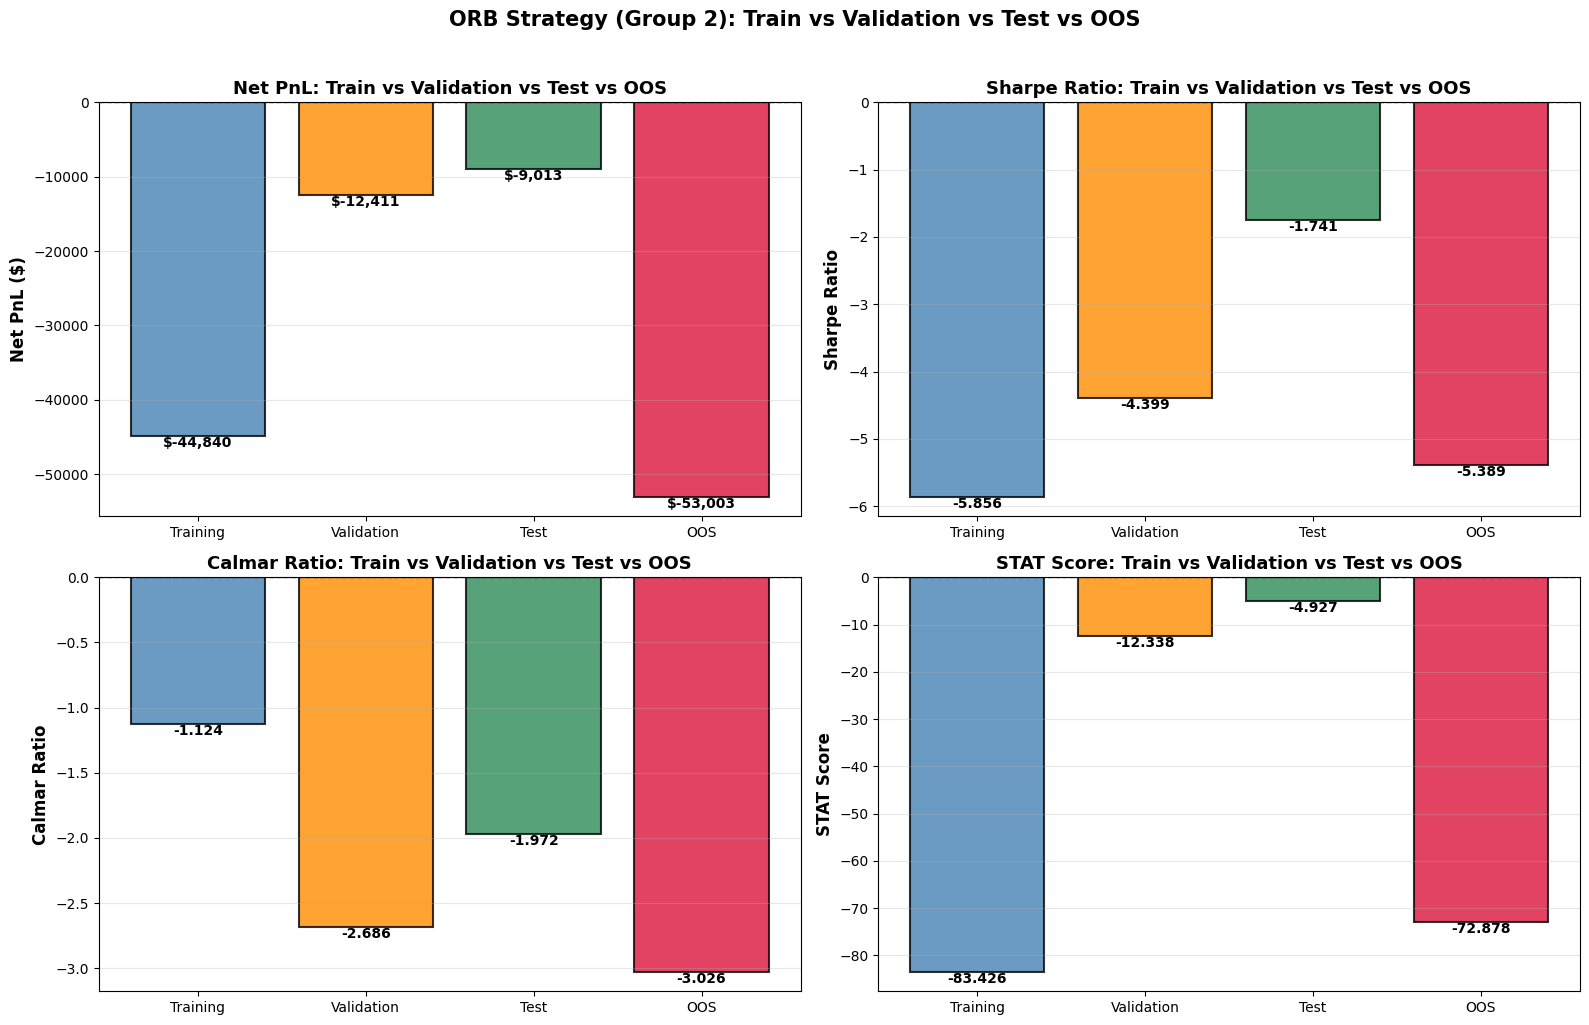


Visualization saved to: outputs_orb_group2_final\train_val_test_oos_comparison.png


In [26]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load optimized portfolio summary (train/val/test)
OUTPUT_DIR_FINAL = Path("outputs_orb_group2_final")
perf_table = pd.read_csv(OUTPUT_DIR_FINAL / "orb_final_summary.csv")
portfolio_results = perf_table[perf_table["asset"] == "PORTFOLIO"].copy()

# Define splits (fallback to defaults if globals missing)
def _fallback(name, default):
    return globals().get(name, default)

train_quarters = _fallback("TRAIN_TAGS", [
    "data2_2023_Q1", "data2_2023_Q3", "data2_2023_Q4", "data2_2024_Q2", "data2_2024_Q4"
])
val_quarters = _fallback("VALIDATION_TAGS", ["data2_2025_Q1"])
test_quarters = _fallback("TEST_TAGS", ["data2_2025_Q2"])

train_res = portfolio_results[portfolio_results["quarter"].isin(train_quarters)]
val_res = portfolio_results[portfolio_results["quarter"].isin(val_quarters)]
test_res = portfolio_results[portfolio_results["quarter"].isin(test_quarters)]

# Helper to summarize a stage

def summarize_stage(df):
    if df.empty:
        return {
            "Net PnL": 0.0,
            "Avg Sharpe": np.nan,
            "Avg Calmar": np.nan,
            "STAT Sum": np.nan,
            "Trades/Day": np.nan,
            "Quarters": 0,
        }
    return {
        "Net PnL": df["net_cumPnL"].sum(),
        "Avg Sharpe": df["netSR"].mean(),
        "Avg Calmar": df["netCR"].mean(),
        "STAT Sum": df["stat"].sum(),
        "Trades/Day": df["av.ntrades"].mean() if "av.ntrades" in df.columns else np.nan,
        "Quarters": len(df),
    }

train_metrics = summarize_stage(train_res)
val_metrics = summarize_stage(val_res)
test_metrics = summarize_stage(test_res)

# Load OOS (ATR) portfolio results
OOS_ATR_PATH = Path("outputs_orb_group2_oos_final/orb_oos_final_summary.csv")
oos_port = pd.read_csv(OOS_ATR_PATH)
oos_port = oos_port[oos_port["asset"] == "PORTFOLIO"].copy()
oos_metrics = summarize_stage(oos_port)

# Summary table
summary_all = pd.DataFrame({
    "Stage": ["Training", "Validation", "Test", "OOS"],
    "Quarters": [train_metrics["Quarters"], val_metrics["Quarters"], test_metrics["Quarters"], oos_metrics["Quarters"]],
    "Net PnL": [train_metrics["Net PnL"], val_metrics["Net PnL"], test_metrics["Net PnL"], oos_metrics["Net PnL"]],
    "Avg Sharpe": [train_metrics["Avg Sharpe"], val_metrics["Avg Sharpe"], test_metrics["Avg Sharpe"], oos_metrics["Avg Sharpe"]],
    "Avg Calmar": [train_metrics["Avg Calmar"], val_metrics["Avg Calmar"], test_metrics["Avg Calmar"], oos_metrics["Avg Calmar"]],
    "STAT Sum": [train_metrics["STAT Sum"], val_metrics["STAT Sum"], test_metrics["STAT Sum"], oos_metrics["STAT Sum"]],
    "Trades/Day": [train_metrics["Trades/Day"], val_metrics["Trades/Day"], test_metrics["Trades/Day"], oos_metrics["Trades/Day"]],
})

print("\n" + "="*100)
print("PORTFOLIO PERFORMANCE: TRAIN / VALIDATION / TEST / OOS")
print("="*100)
print(summary_all.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))
print("="*100)

# Visualization: bar charts similar to Strategy1 - Group 1
categories = ["Training", "Validation", "Test", "OOS"]
colors = ['steelblue', 'darkorange', 'seagreen', 'crimson']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Net PnL
ax1 = axes[0, 0]
pnls = summary_all["Net PnL"].tolist()
bars1 = ax1.bar(categories, pnls, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(0, color='black', linestyle='--', linewidth=1.0, alpha=0.7)
ax1.set_ylabel('Net PnL ($)', fontsize=12, fontweight='bold')
ax1.set_title('Net PnL: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax1.grid(True, axis='y', alpha=0.3)
for bar, pnl in zip(bars1, pnls):
    ax1.text(bar.get_x() + bar.get_width()/2., pnl,
             f"${pnl:,.0f}", ha='center', va='bottom' if pnl >= 0 else 'top',
             fontweight='bold', fontsize=10)

# Sharpe
ax2 = axes[0, 1]
sharpes = summary_all["Avg Sharpe"].tolist()
bars2 = ax2.bar(categories, sharpes, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=1.0, alpha=0.7)
ax2.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax2.set_title('Sharpe Ratio: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
for bar, s in zip(bars2, sharpes):
    ax2.text(bar.get_x() + bar.get_width()/2., s,
             f"{s:.3f}" if pd.notna(s) else "NA", ha='center', va='bottom' if (pd.notna(s) and s >= 0) else 'top',
             fontweight='bold', fontsize=10)

# Calmar
ax3 = axes[1, 0]
calmars = summary_all["Avg Calmar"].tolist()
bars3 = ax3.bar(categories, calmars, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.axhline(0, color='black', linestyle='--', linewidth=1.0, alpha=0.7)
ax3.set_ylabel('Calmar Ratio', fontsize=12, fontweight='bold')
ax3.set_title('Calmar Ratio: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax3.grid(True, axis='y', alpha=0.3)
for bar, c in zip(bars3, calmars):
    label = f"{c:.3f}" if pd.notna(c) else "NA"
    ax3.text(bar.get_x() + bar.get_width()/2., c if pd.notna(c) else 0,
             label, ha='center', va='bottom' if (pd.notna(c) and c >= 0) else 'top',
             fontweight='bold', fontsize=10)

# STAT
ax4 = axes[1, 1]
stats_comp = summary_all["STAT Sum"].tolist()
bars4 = ax4.bar(categories, stats_comp, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.axhline(0, color='black', linestyle='--', linewidth=1.0, alpha=0.7)
ax4.set_ylabel('STAT Score', fontsize=12, fontweight='bold')
ax4.set_title('STAT Score: Train vs Validation vs Test vs OOS', fontsize=13, fontweight='bold')
ax4.grid(True, axis='y', alpha=0.3)
for bar, st in zip(bars4, stats_comp):
    label = f"{st:.3f}" if pd.notna(st) else "NA"
    ax4.text(bar.get_x() + bar.get_width()/2., st if pd.notna(st) else 0,
             label, ha='center', va='bottom' if (pd.notna(st) and st >= 0) else 'top',
             fontweight='bold', fontsize=10)

plt.suptitle('ORB Strategy (Group 2): Train vs Validation vs Test vs OOS', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR_FINAL / "train_val_test_oos_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {OUTPUT_DIR_FINAL / 'train_val_test_oos_comparison.png'}")